This notebook covers three model implementations:

1. A physics based model based on the Gompertz function
2. To train an LSTM model (data-driven-model) to predict a sequence (e.g., battery capacity over time)
3. To train an LSTM model to predict a sequence (e.g., battery capacity over time) while ensuring it respects physical behavior modeled by the Gompertz function.


## FIXES 

### Fix 1 : Added Sanity Check for val loss and val rmse

Explanation:
Issue	Fix	Why
torch.Tensor()	→ torch.tensor()	The lowercase version is the recommended constructor for creating a single-value tensor.
Missing closing parenthesis	Added	Fixes syntax error.
avg_val_loss type	Ensure it’s a scalar (float or int)	If it’s already a tensor, remove the outer torch.tensor() call.

### Fix 2: Use log loss in calculation of metric charts
### Fix 3: Update reproducibility
### Fix 4: time GPU run
### Fix 5: LSTMs that predict RUL given initial x SoH values.

In [1]:

print("# A: Import Libraries and set reproducibility")
# !git clone https://github.com/Yuri-Njathi/battery-lstm-ML.git
# import sys
# sys.path.append("battery-lstm-ML/")


import torch
import numpy as np
import random
import os
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error
from typing import Callable, Optional

def set_seed(seed=42):
    """
    Set all relevant random seeds to ensure full reproducibility.
    """
    # 1. Set basic seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multiple GPUs
    
    # 2. Force deterministic behavior in cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # turn off auto-tuning
    
    # 3. Optional: make dataloaders deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  # deterministic cublas (for CUDA >= 10.2)

    print(f"✅ Reproducibility environment set with seed = {seed}")

# Call this once at the start, pull from assess
set_seed(42)

'''
set mode i.e.
0 == physics based
1 == lstm (data driven) #SoH only 
2 == lstm (physics constrained)
'''
mode = 2

if mode == 1:
    model_columns = ['SoH', 'Cycle number']
if mode == 2:
    model_columns = ['SoH']



print("# B: Setup variables and functions")
# # Set variables
# WINDOW_SIZE = 35
model_type = ['lstm','seq2seq-lstm','pinn'][2]

cutoff_soh = 0.70
# Set Computing Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = len(model_columns)
OUTPUT_SIZE =3 #RUL #len(model_columns)#1 #controls how many values the lstm outputs
num_epochs = 200 #60
batch_size = 4 #32 #because the data is little a small batch size is better when training
normalize_soh = False
if normalize_soh:
    soh_normalization_constant = 115.0 #115.0 may be better as it allows bounding between 0 and 1
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer
else:
    soh_normalization_constant = 1.0
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer

print("Cutoff SoH : ",cutoff_soh)

def df_to_X_y_tensor(df, window_size=5,output_size=5):
    '''
    Converts a time series into (X, y) tensors for LSTM training.
    
    X shape: (num_samples, window_size, 1)
    y shape: (num_samples, 1)
    '''
    # if isinstance(df, (pd.DataFrame, pd.Series)):
    #     df_as_np = df.to_numpy()
    # else:
    #     df_as_np = df  # Assume already numpy

    X, y , y2 = [], [], []
    #for i in range(len(df_as_np) - window_size):
    X.append(list(df['SoH'])[:window_size+1])
    #y.append([df_as_np[i + window_size:i + window_size+output_size]])
    y.append([list(df['k'])[-1],list(df['a'])[-1],list(df['b'])[-1]])
    #append([[val] for val in df_as_np[i + window_size:i + window_size+1]]) #next cycle
    y2.append(list(df['rul'])[:1])
    X,y,y2 = np.array(X),np.array(y), np.array(y2)
    X_tensor = torch.tensor(X, dtype=torch.float32)#.squeeze()
    y_tensor = torch.tensor(y, dtype=torch.float32)#.squeeze()
    y_2_tensor = torch.tensor(y2, dtype=torch.float32)  #bug was here written y instead of y2
    return X_tensor, y_tensor, y_2_tensor

def get_x_y_lists(paths):
    X_list,y_list,y_target = [],[],[]
    for path in paths:
        print(path)
        df = pd.read_csv(path)
        df['Cycle number'] = df['Cycle number']/10000
        df['rul'] = df['rul']/10000
        #normalize SoH
        df['SoH'] =  df['SoH']/soh_normalization_constant
        df.index = df['Cycle number']
        #SoH = df[model_columns]
        X, y , y1 = df_to_X_y_tensor(df, window_size=WINDOW_SIZE,output_size=OUTPUT_SIZE)
        X_list.append(X)
        y_list.append(y)
        y_target.append(y1) #RUL
    return X_list,y_list, y_target

# def give_paths_get_loaders(paths,data_type,shuffle=False):
#     X_list, y_list, y_target = get_x_y_lists(paths)

#     if INPUT_SIZE == 1:
#         # Concatenate all X and y
#         X_1,y_1,y_2 = torch.cat(X_list, dim=0).squeeze(-1),torch.cat(y_list, dim=0).view(-1,OUTPUT_SIZE).squeeze(-1)
#     else:
#         X_1,y_1, y_2 = torch.cat(X_list, dim=0), torch.cat(y_list, dim=0), torch.cat(y_target, dim=0).view(-1,OUTPUT_SIZE).squeeze(-1)#.view(-1, OUTPUT_SIZE)
    
#     print(f"X_{data_type} , y_{data_type} shapes : ",X_1.shape, y_1.shape)
    
#     #DataLoader
#     print("load : ")
#     loader = DataLoader(TensorDataset(X_1, y_1), batch_size=32, shuffle=shuffle)
#     print(f"{data_type}loader lengths : ",loader.__len__())
#     return loader,X_1,y_1,y2



print("## 🧠 Model Architecture")



class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=5):
        super(LSTMModel, self).__init__()
        
        # LSTM: input_size=5 match your features
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Linear Layer: Maps hidden_size (64) -> output_size (5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [32, 10, 5]
        
        # Run LSTM
        # lstm_out shape: [32, 10, 64]
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step only
        last_time_step = lstm_out[:, -1, :] 
        # last_time_step shape: [32, 64]
        
        # Project to 5 output features
        prediction = self.fc(last_time_step)
        # prediction shape: [32, 5]
        
        return prediction

class PhysicsInformedLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64):
        super(PhysicsInformedLSTM, self).__init__()
        
        # 1. LSTM Core
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 2. Split Heads (One for each parameter)
        # We split them so we can apply different activations to each
        self.fc_k = nn.Linear(hidden_size, 1)
        self.fc_a = nn.Linear(hidden_size, 1)
        self.fc_b = nn.Linear(hidden_size, 1)
        
        # Activation to force k > 0 (Capacity cannot be negative)
        self.softplus = nn.Softplus()

    def forward(self, x):
        # x shape: [Batch, Window, Feats]
        
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step
        last_time_step = lstm_out[:, -1, :] 
        
        # --- PREDICT PARAMETERS SEPARATELY ---
        
        # 1. Predict k (Enforce Positive)
        # Softplus ensures output is always > 0
        k_pred = self.softplus(self.fc_k(last_time_step))
        
        # 2. Predict a (Can be negative or positive)
        a_pred = self.fc_a(last_time_step)
        
        # 3. Predict b (Usually small positive, but let's keep it linear for now)
        b_pred = self.fc_b(last_time_step)
        
        # Concatenate them back into shape [Batch, 3]
        prediction = torch.cat([k_pred, a_pred, b_pred], dim=1)
        
        return prediction


class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mid_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, mid_size)
        self.fc2 = nn.Linear(mid_size, output_size)

    def forward(self, x):
        # out: [batch_size, seq_len, hidden_size]
        out, _ = self.lstm(x)

        # Apply the linear layers to each timestep
        mid = self.relu(self.fc1(out))   # shape: [batch, seq_len, mid_size]
        out_seq = self.fc2(mid)          # shape: [batch, seq_len, output_size]

        return out_seq


    #on initial tensorflow experiments I used 1,64,1,1 for those values.

### TEST ON SEQUENTIAL MODEL ###
# model(torch.Tensor([[86.4707],[86.4150],[86.3590],[86.3035],[86.2506],[86.2512],[86.1954],[86.1403],[86.1427],[86.0904],[86.0373],[85.9772],[85.9743],[85.9198],[85.8654],[85.8090],[85.8077],[85.7524],[85.6986],[85.6407],[85.5883],[85.5882],[85.6112],[85.4756],[85.4753],[85.4187],[85.3639],[85.3086],[85.3098],[85.3628],[85.1723],[85.1430],[85.1444],[85.0896],[85.0364]]))

# A: Import Libraries and set reproducibility
✅ Reproducibility environment set with seed = 42
# B: Setup variables and functions
Cutoff SoH :  0.7
## 🧠 Model Architecture


#### “Normalization” ≠ “scaling to [0,1]”.

#### It simply means rescaling values to a stable, comparable numerical range.

# C: Setup Train, Val and Test Loaders
# 0. Data

Each `X_train` is of shape `(num_samples, window_size)`

Each `y_train` is of shape `(num_samples,)` (usually next value prediction)

##  🧰 Convert to Tensors for LSTM
LSTM expects input shape: (batch_size, sequence_length, num_features)

Let’s reshape the data and convert it:

In [2]:
import re

In [3]:
WINDOW_SIZES = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100,500,1000] #[i for i in range (5,100,5)]
print("WINDOW SIZES TO TEST : ",WINDOW_SIZES,len(WINDOW_SIZES))


# Make list of CSV paths
main_files_path = '/kaggle/input/generate-hust-data-gompertz-k-a-b/'
#/kaggle/input/generate-hust-data-gompertz-k-a-b/1-2-hust_gompertz_params.csv
csv_files = os.listdir(main_files_path)
csv_files = [f for f in csv_files if re.match(r'^\d', f) and f.endswith('-hust_gompertz_params.csv')]

#BatteryML like train-val-test split
csv_files = [f.removesuffix('-hust_gompertz_params.csv') for f in csv_files]
print(csv_files)

train_ids = [
    '1-3',  '1-4',  '1-5',  '1-6',  '1-7',  '1-8',  '2-2',  '2-3',
    '2-4',  '2-6',  '2-7',  '2-8',  '3-2',  '3-3',  '3-4',  '3-5',
    '3-6',  '3-7',  '3-8',  '4-1',  '4-2',  '4-3',  '4-4',  '4-6',
    '4-7',  '4-8',  '5-1',  '5-2',  '5-4',  '5-5',  '5-6',  '5-7',
    '6-3',  '6-4',  '6-5',  '7-1',  '7-2',  '7-3',  '7-4',  '7-7',
    '7-8',  '8-2',  '8-3',  '8-4',  '8-7',  '9-1',  '9-2',  '9-3',
    '9-5',  '9-7',  '9-8',  '10-2', '10-3', '10-5', '10-8']

test_ids = [f for f in csv_files if f not in train_ids]

print(test_ids,len(test_ids))

#csv_paths = [os.path.join(main_files_path, file) for file in csv_files]
#separate according to train, val and test
train_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in train_ids]

testing_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in test_ids]

val_paths = testing_paths[:int(len(testing_paths)*0.5)]
test_paths = testing_paths[int(len(testing_paths)*0.5):]

print(len(train_paths), len(val_paths), len(test_paths))

WINDOW SIZES TO TEST :  [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 500, 1000] 16
['6-6', '8-7', '8-6', '9-1', '10-1', '6-8', '8-8', '10-7', '3-5', '5-1', '5-5', '7-1', '2-7', '10-6', '4-7', '7-7', '7-6', '4-5', '9-2', '10-4', '3-1', '9-7', '8-1', '10-8', '8-4', '4-6', '4-4', '3-8', '5-4', '9-6', '10-5', '7-8', '5-2', '9-8', '1-2', '5-6', '10-2', '2-6', '6-1', '2-4', '1-4', '4-1', '1-6', '6-2', '8-5', '5-7', '1-5', '1-8', '5-3', '6-5', '9-5', '4-8', '7-2', '2-5', '7-3', '9-3', '9-4', '8-2', '10-3', '6-3', '3-2', '7-5', '3-7', '2-3', '1-3', '8-3', '2-8', '7-4', '4-2', '6-4', '1-1', '3-3', '4-3', '3-4', '2-2', '1-7', '3-6']
['6-6', '8-6', '10-1', '6-8', '8-8', '10-7', '10-6', '7-6', '4-5', '10-4', '3-1', '8-1', '9-6', '1-2', '6-1', '6-2', '8-5', '5-3', '2-5', '9-4', '7-5', '1-1'] 22
55 11 11


## 🧠 Model
Last model window :  last_model_window_5_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust_gompertz_params.csv
/kaggle/i

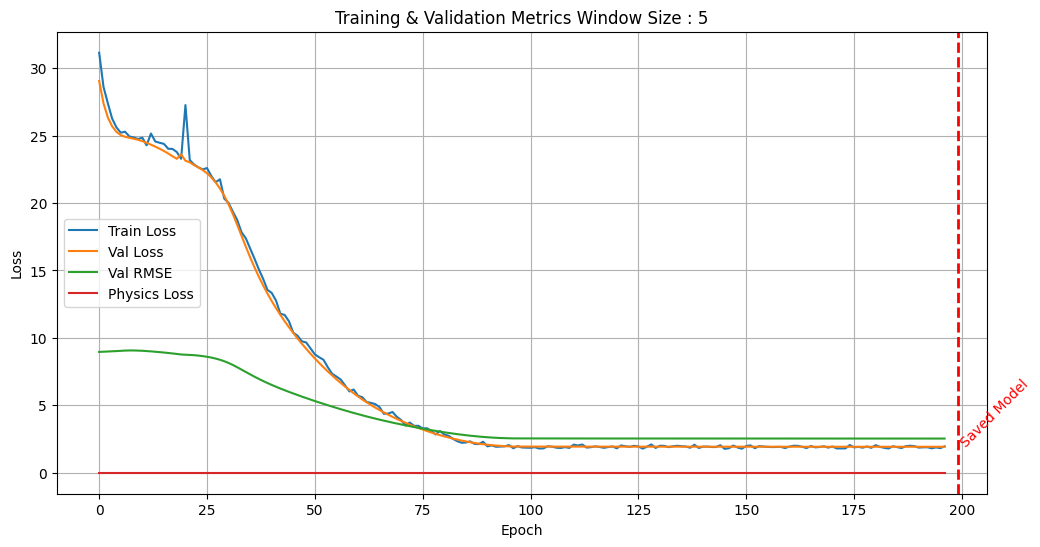

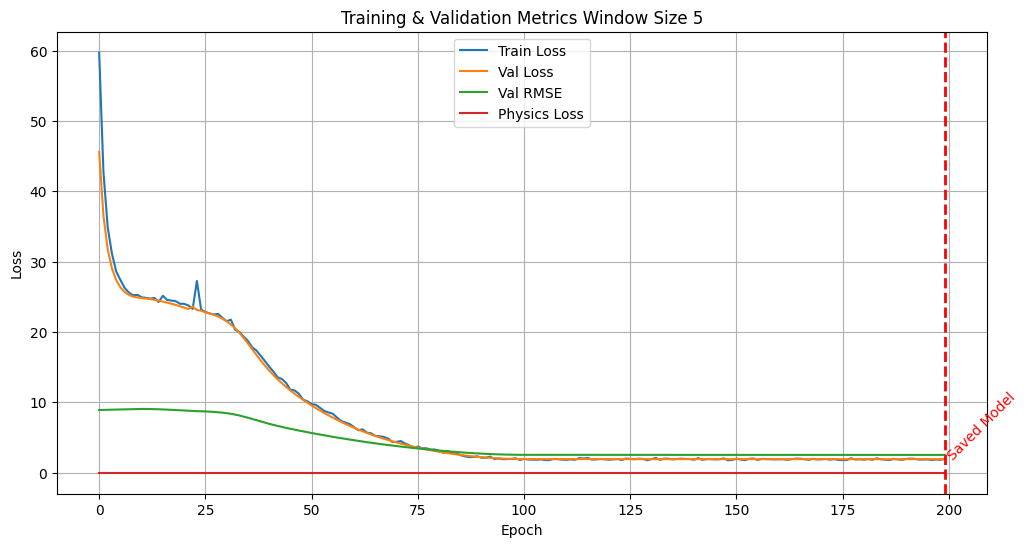

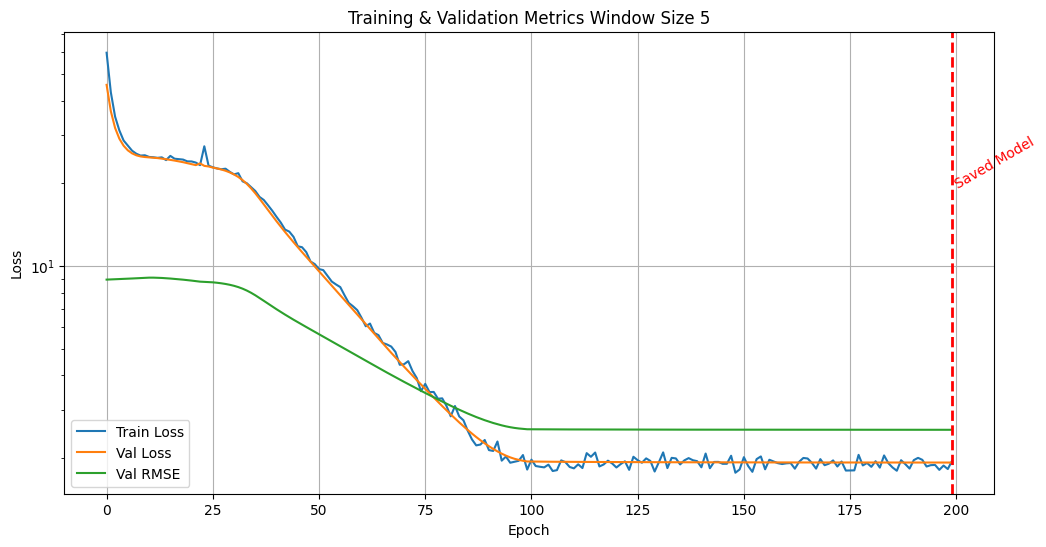

Test RMSE :  1.7705026865005493
## 🧠 Model
Last model window :  last_model_window_10_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

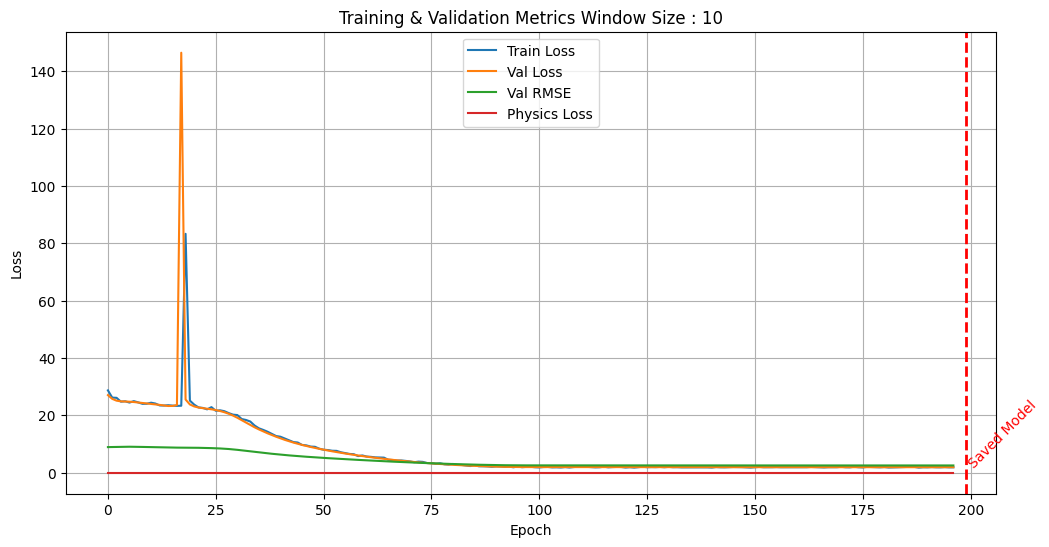

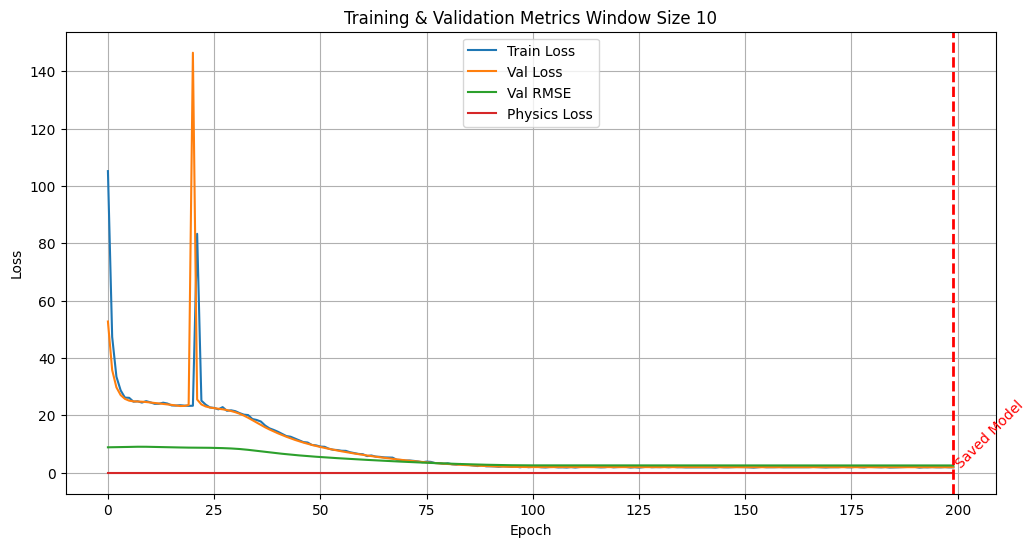

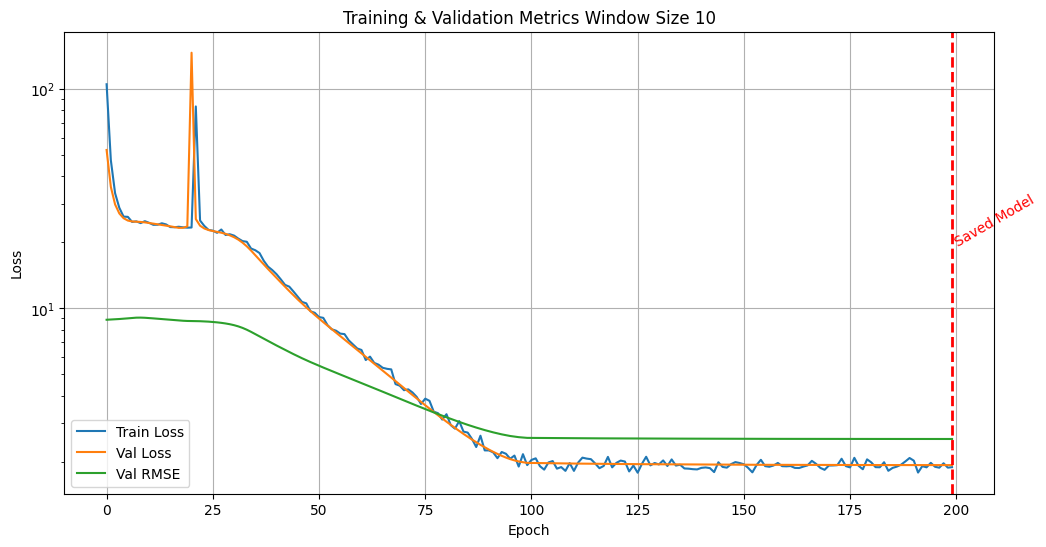

Test RMSE :  1.7747087478637695
## 🧠 Model
Last model window :  last_model_window_15_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

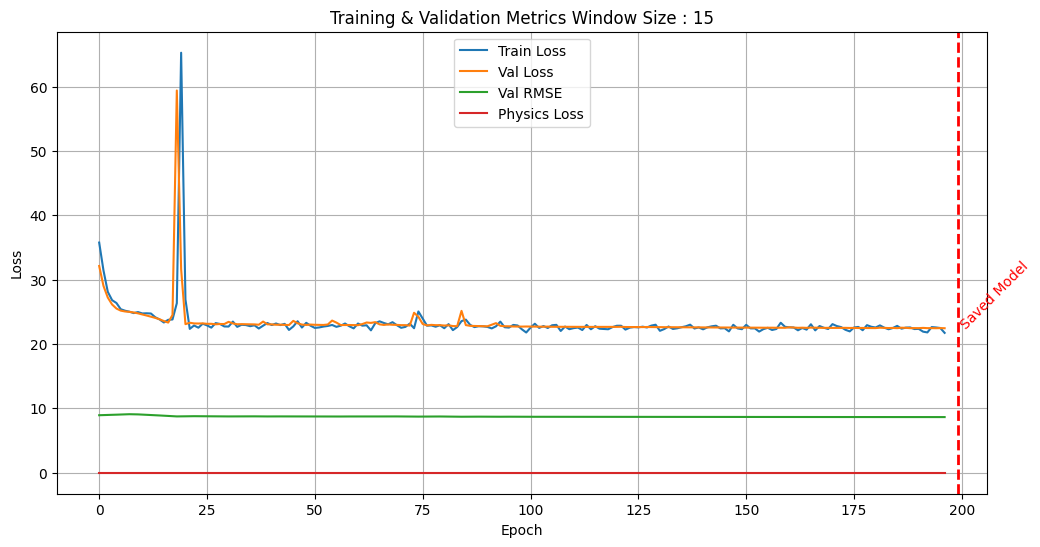

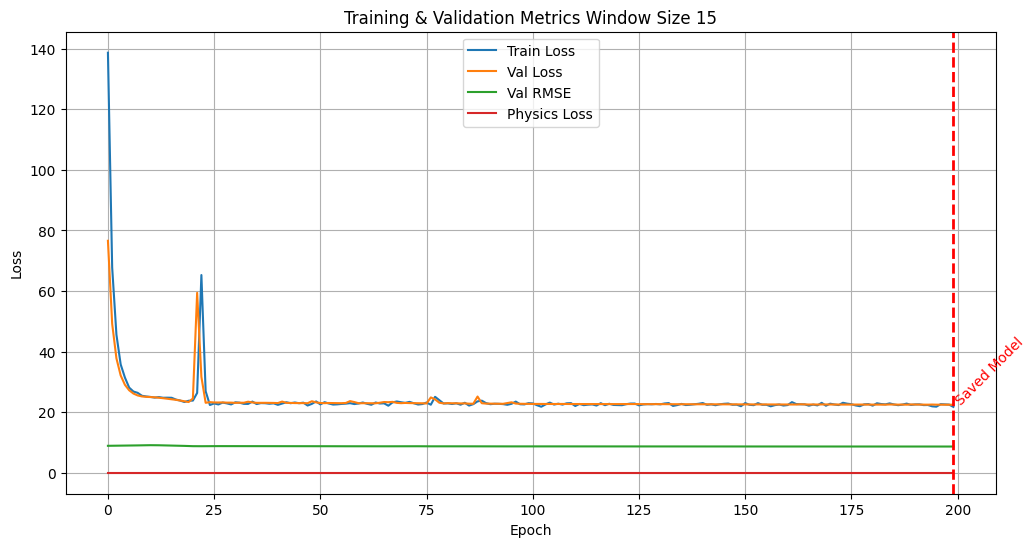

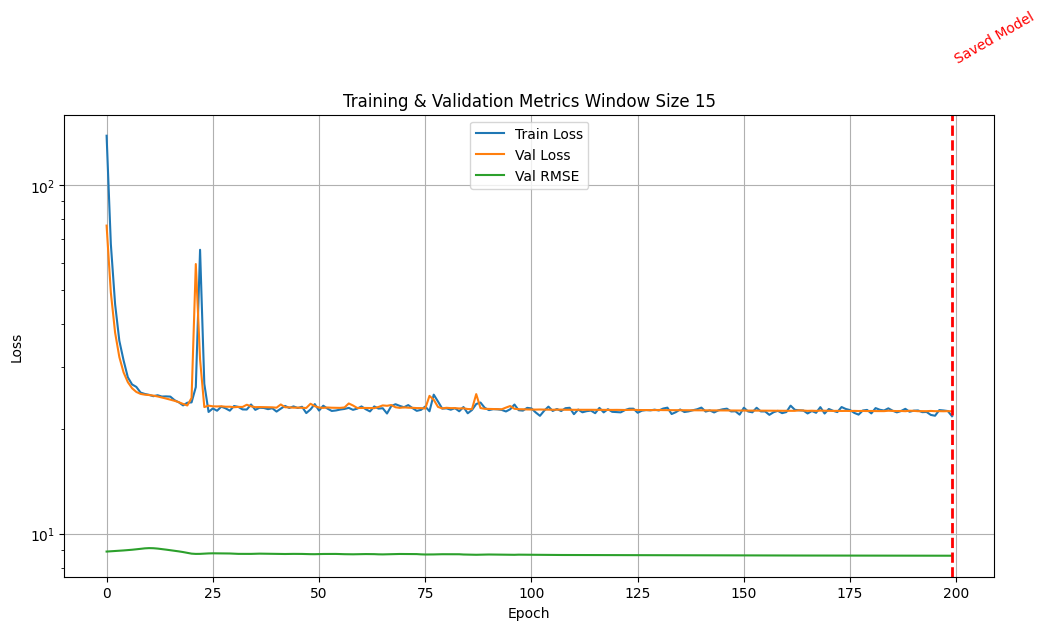

Test RMSE :  5.994290828704834
## 🧠 Model
Last model window :  last_model_window_20_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hu

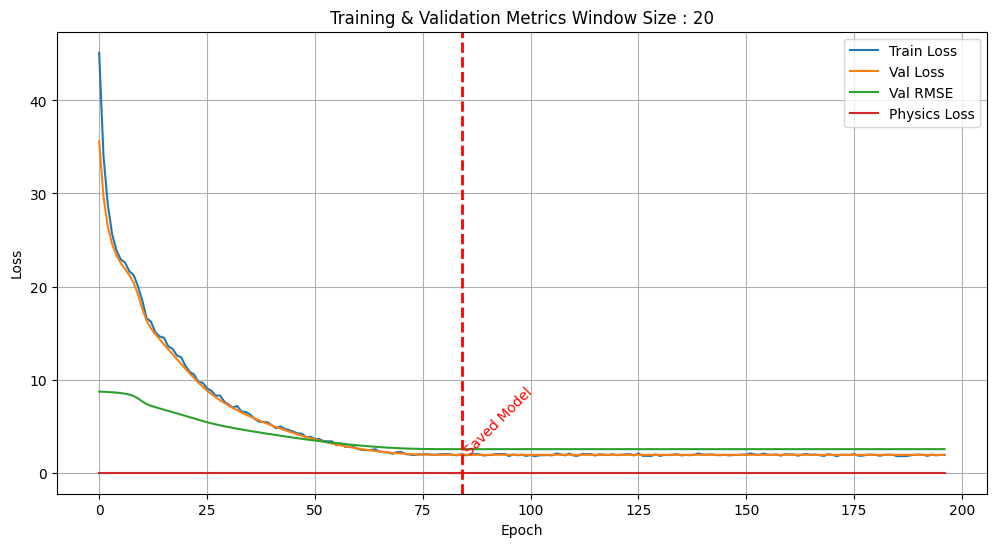

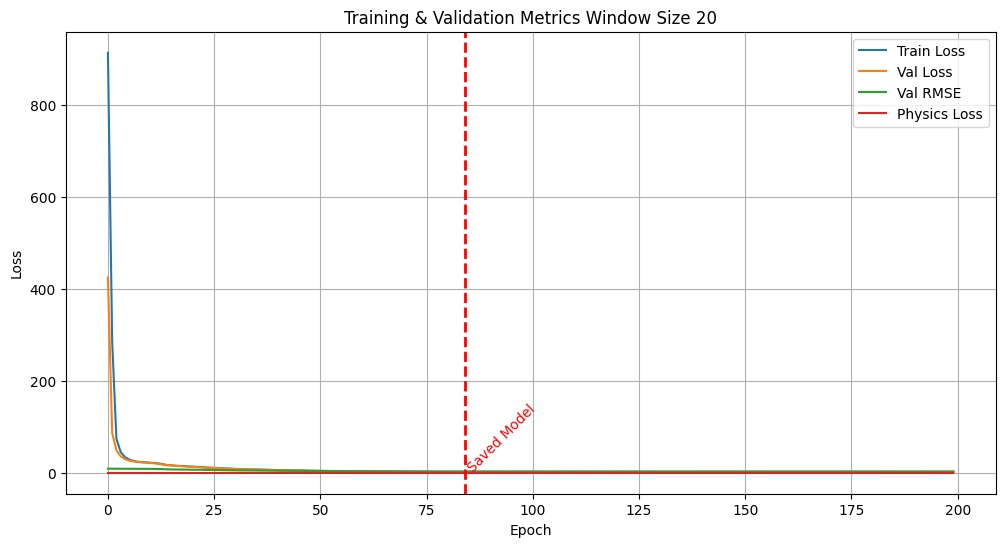

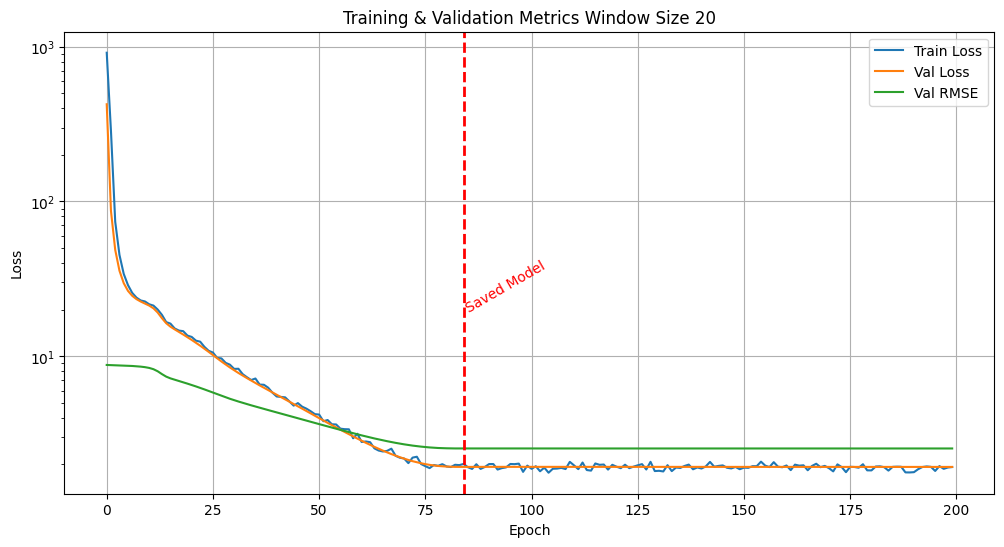

Test RMSE :  1.7649627923965454
## 🧠 Model
Last model window :  last_model_window_25_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

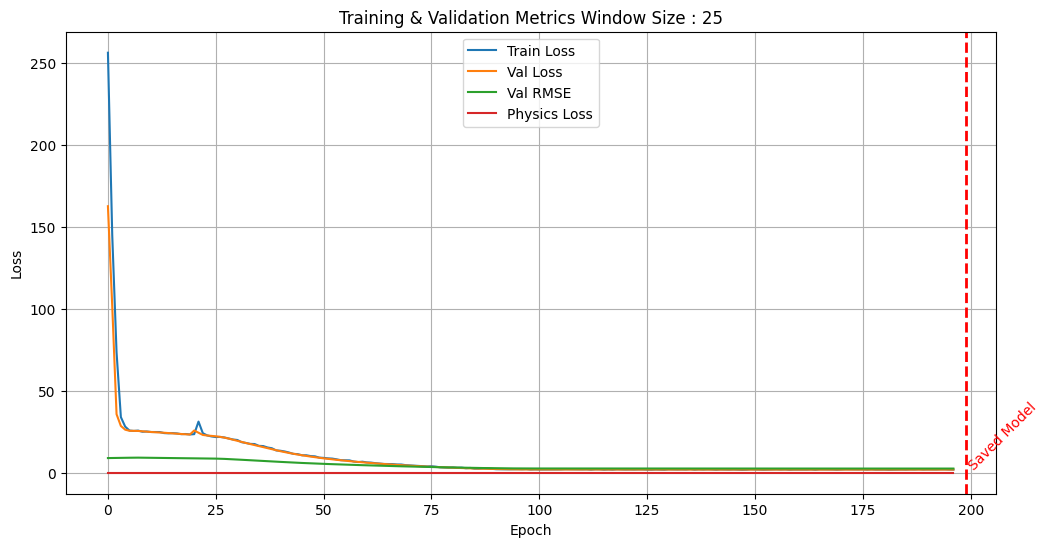

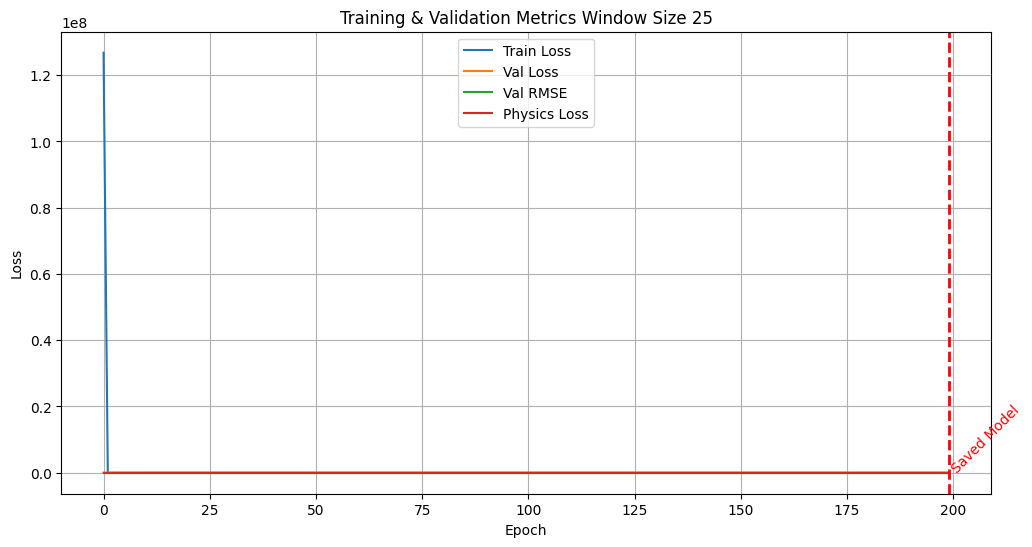

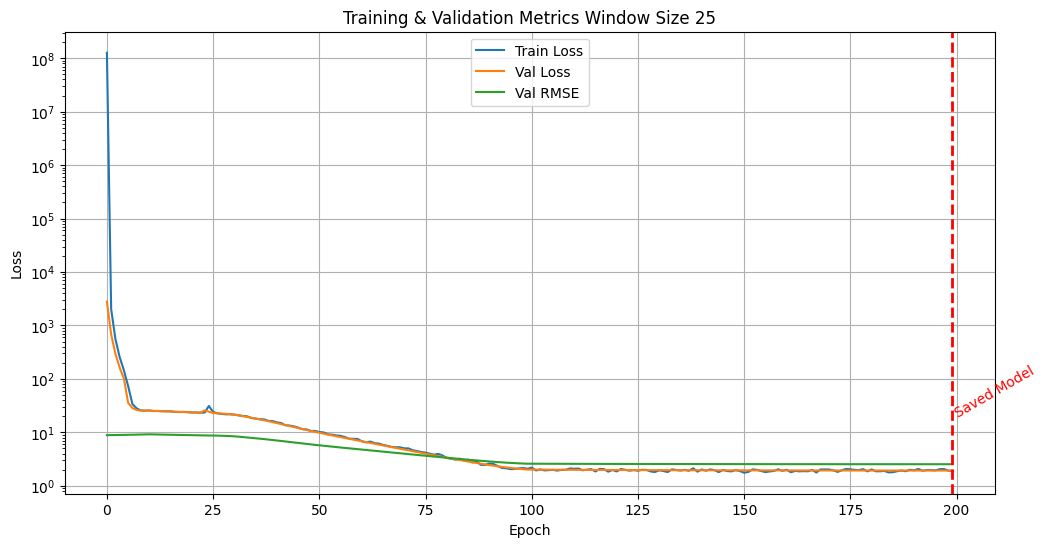

Test RMSE :  1.7811461687088013
## 🧠 Model
Last model window :  last_model_window_30_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

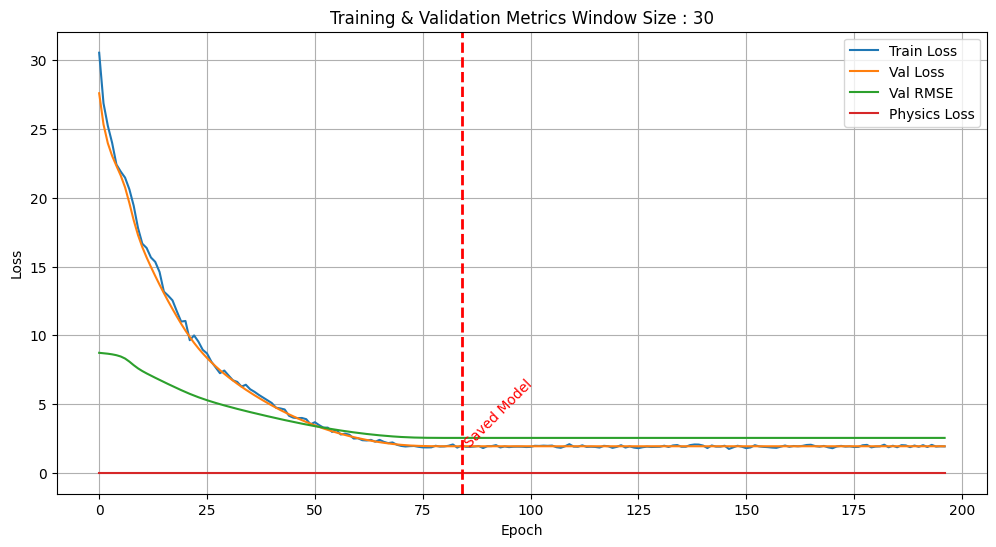

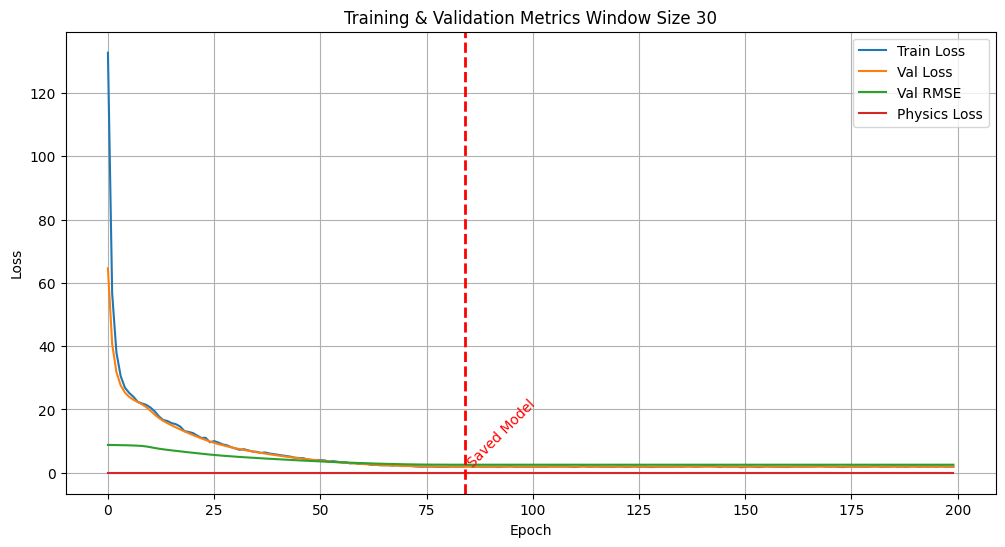

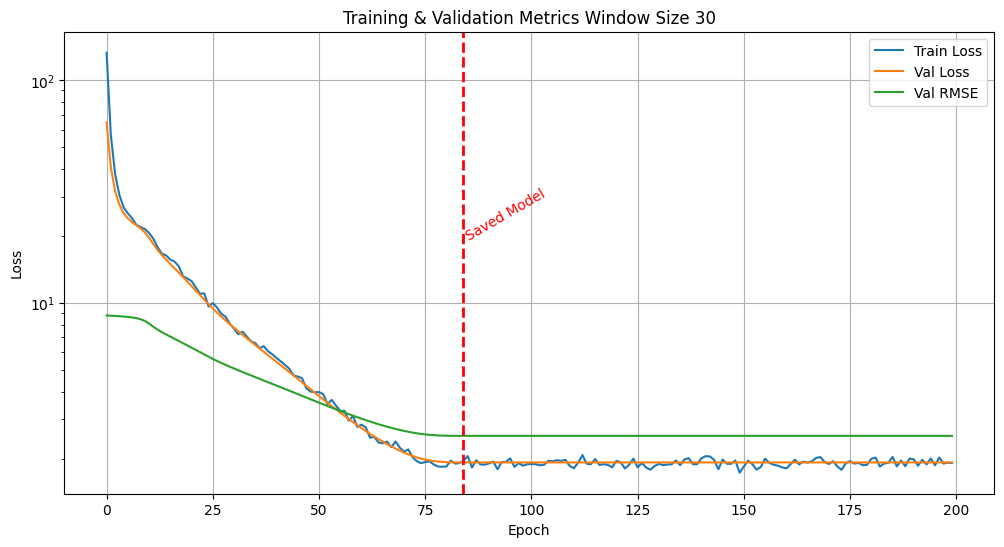

Test RMSE :  1.7648544311523438
## 🧠 Model
Last model window :  last_model_window_35_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

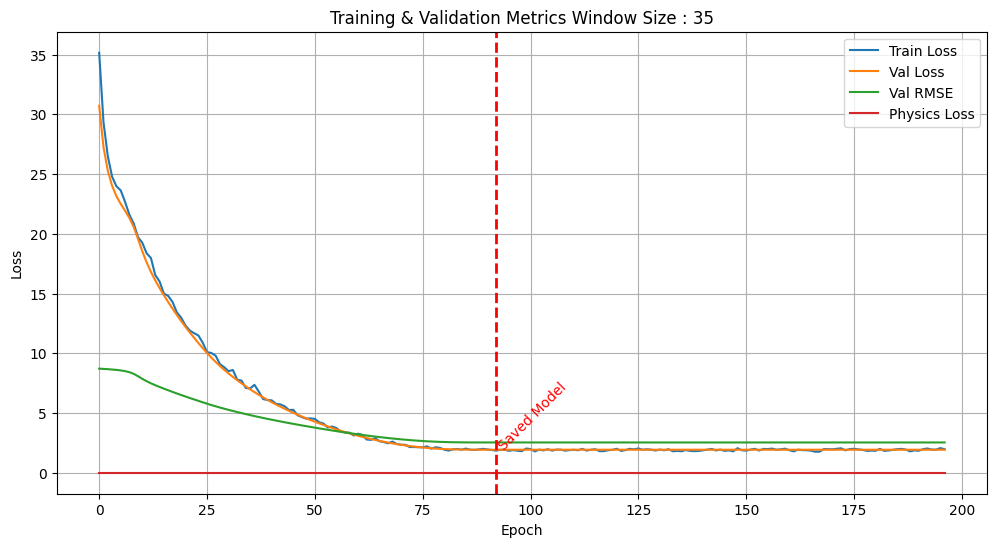

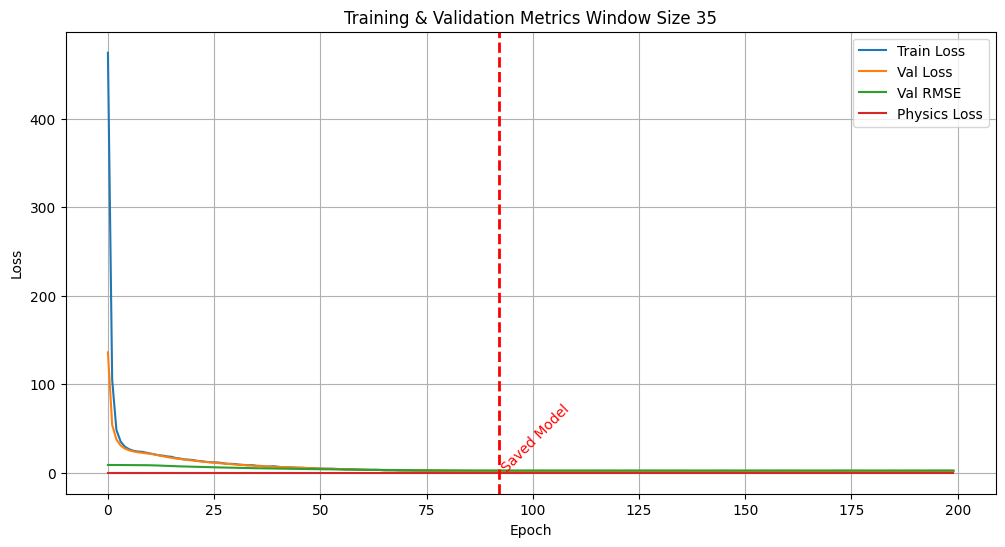

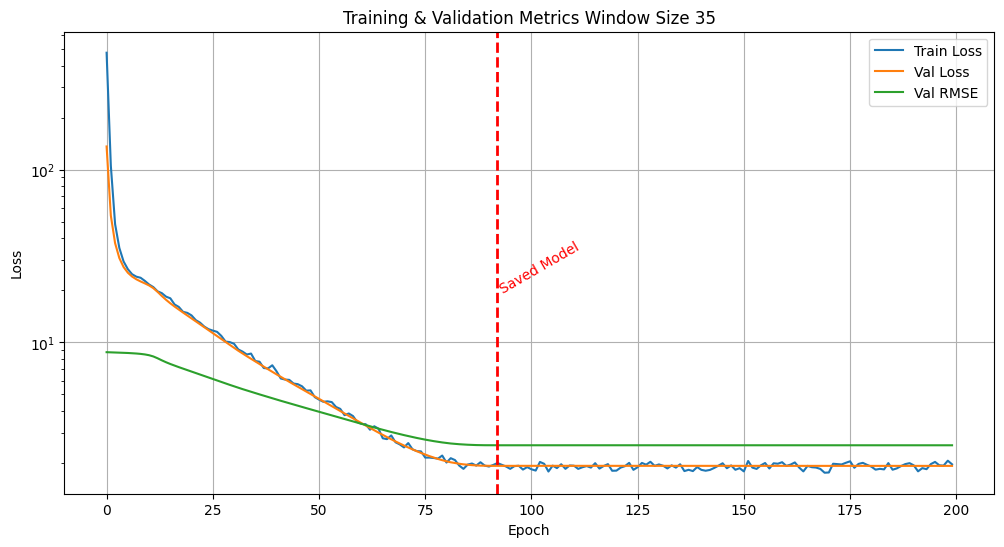

Test RMSE :  1.7655643224716187
## 🧠 Model
Last model window :  last_model_window_40_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

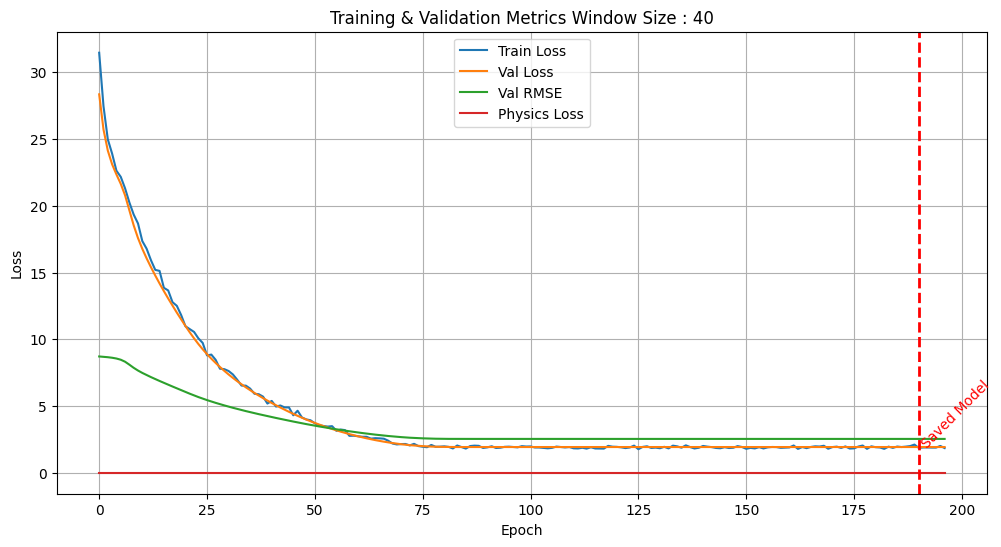

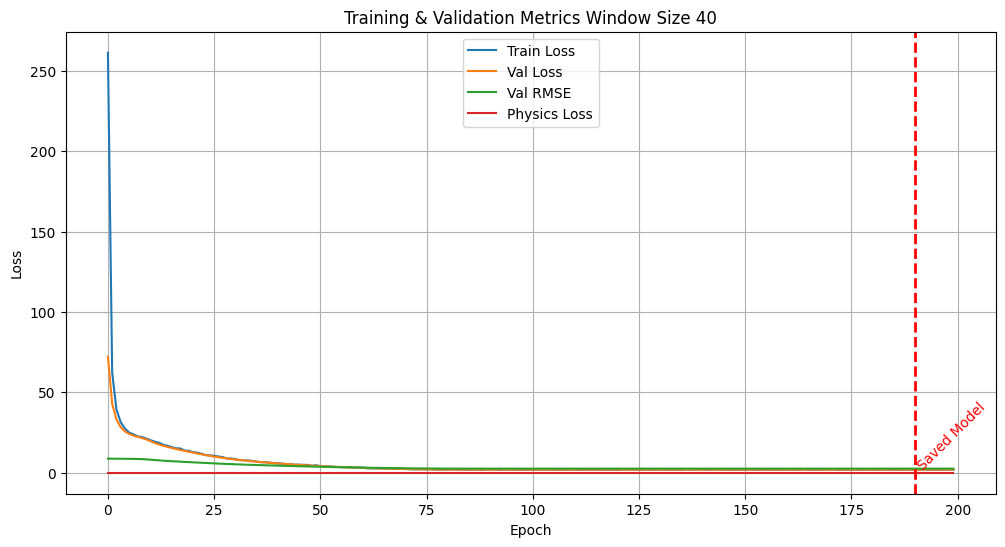

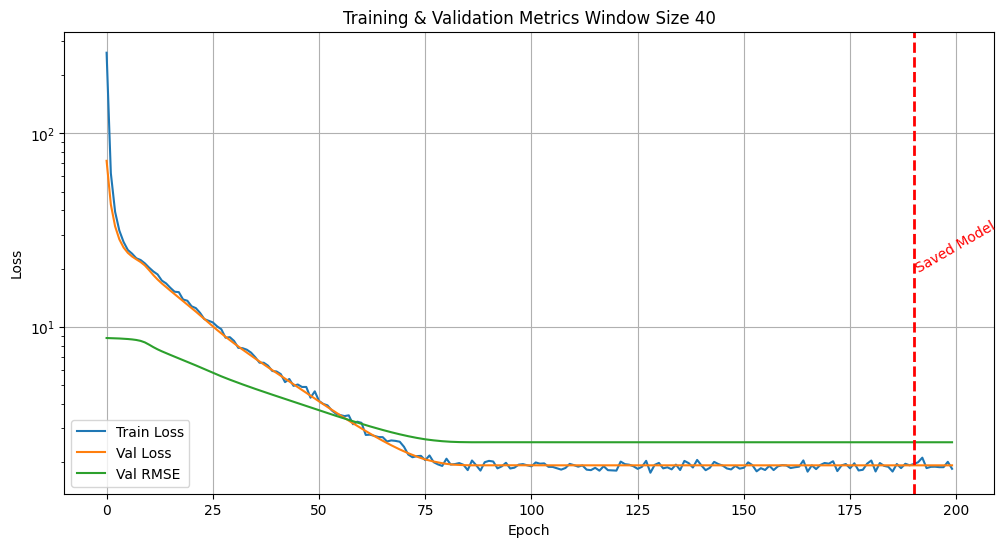

Test RMSE :  1.7654634714126587
## 🧠 Model
Last model window :  last_model_window_50_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

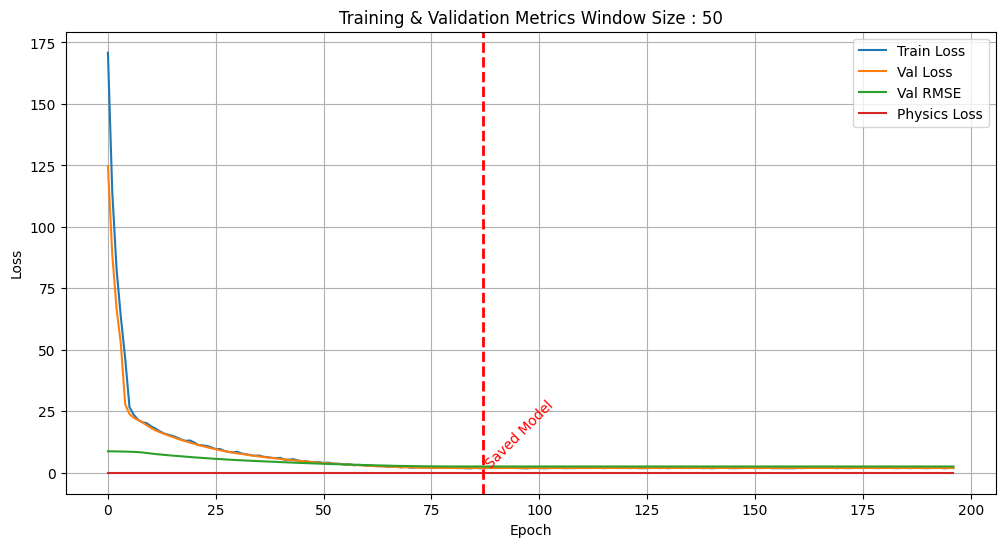

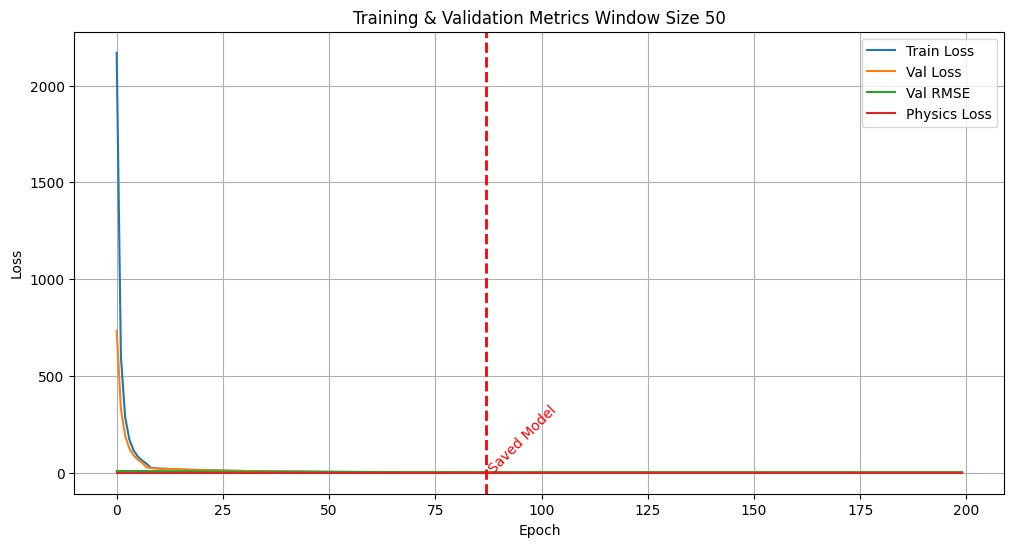

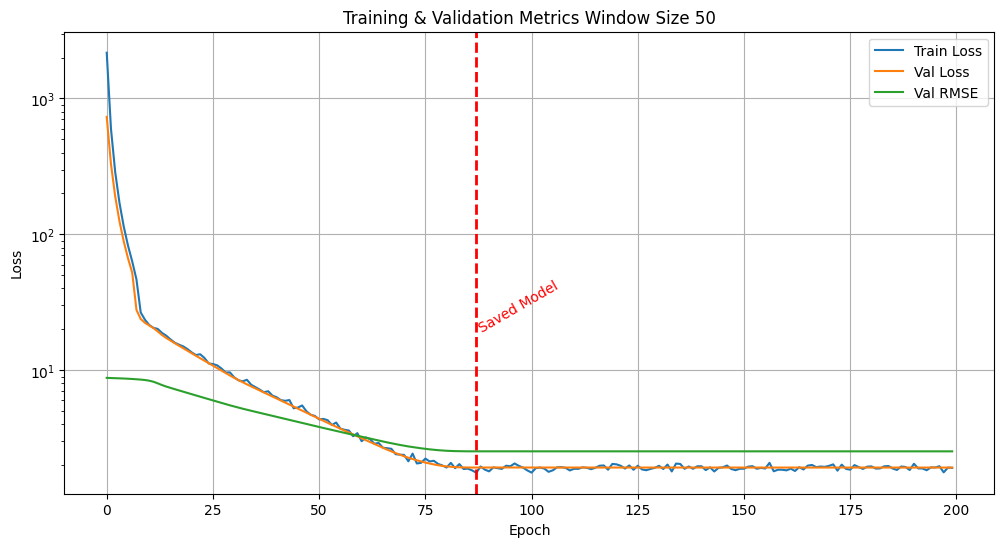

Test RMSE :  1.7657989263534546
## 🧠 Model
Last model window :  last_model_window_60_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

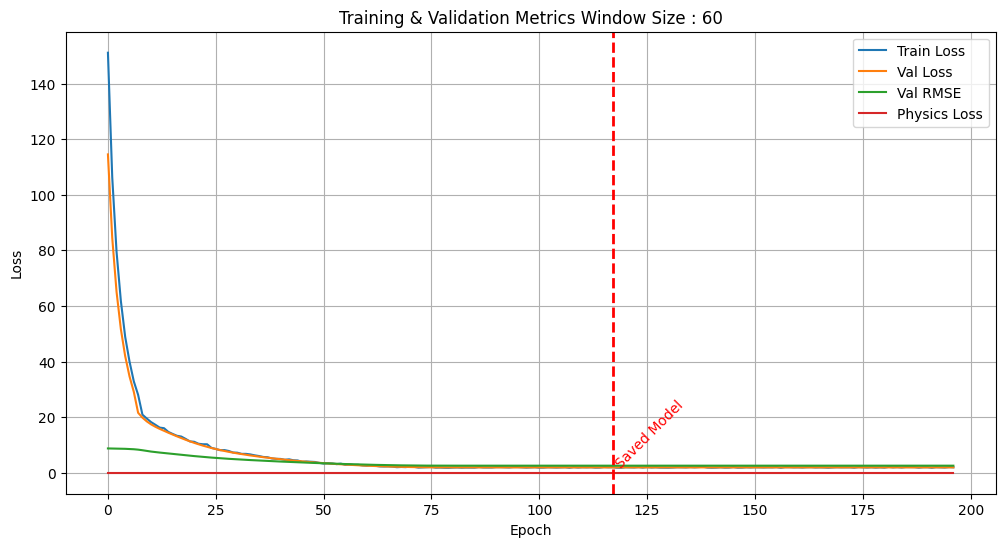

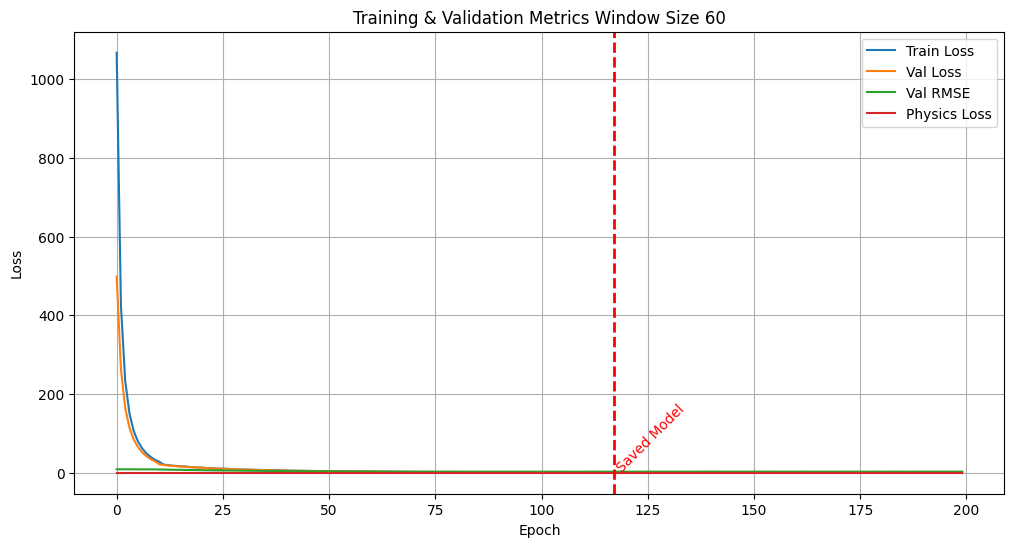

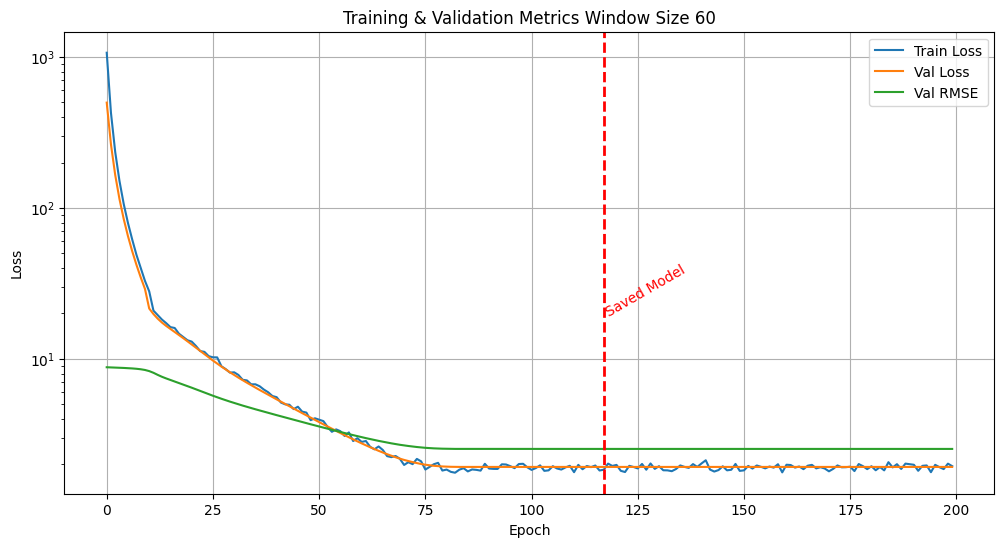

Test RMSE :  1.7665314674377441
## 🧠 Model
Last model window :  last_model_window_70_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

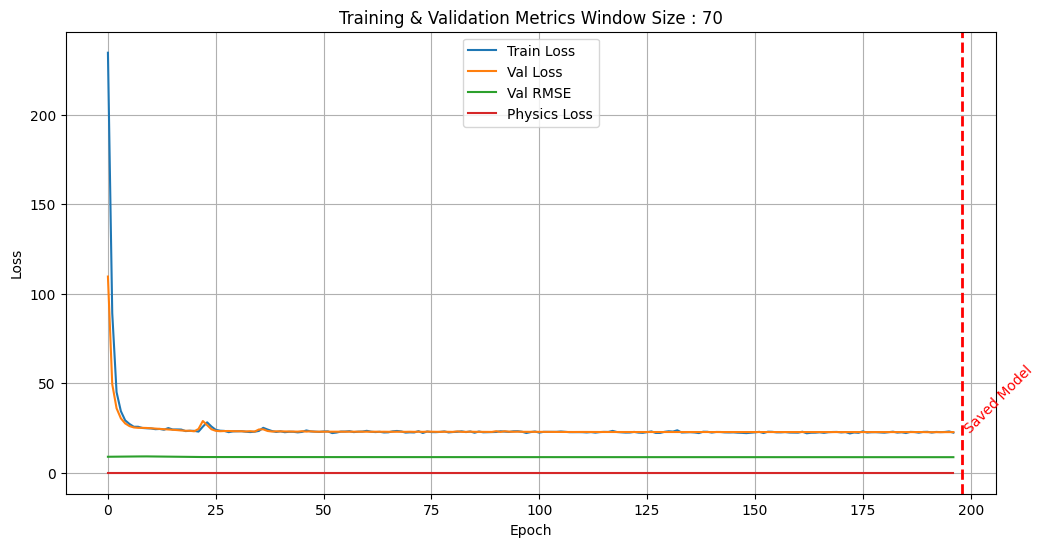

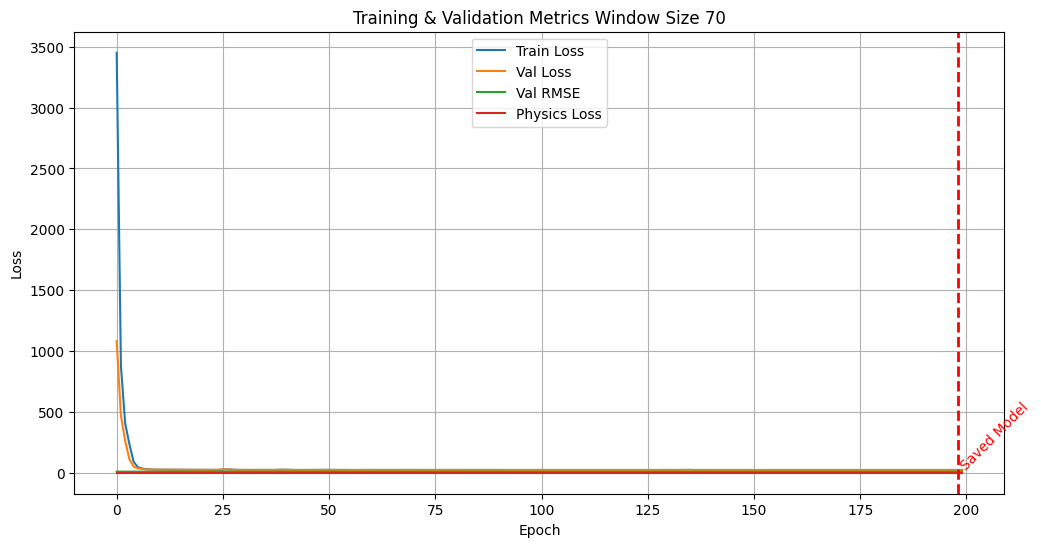

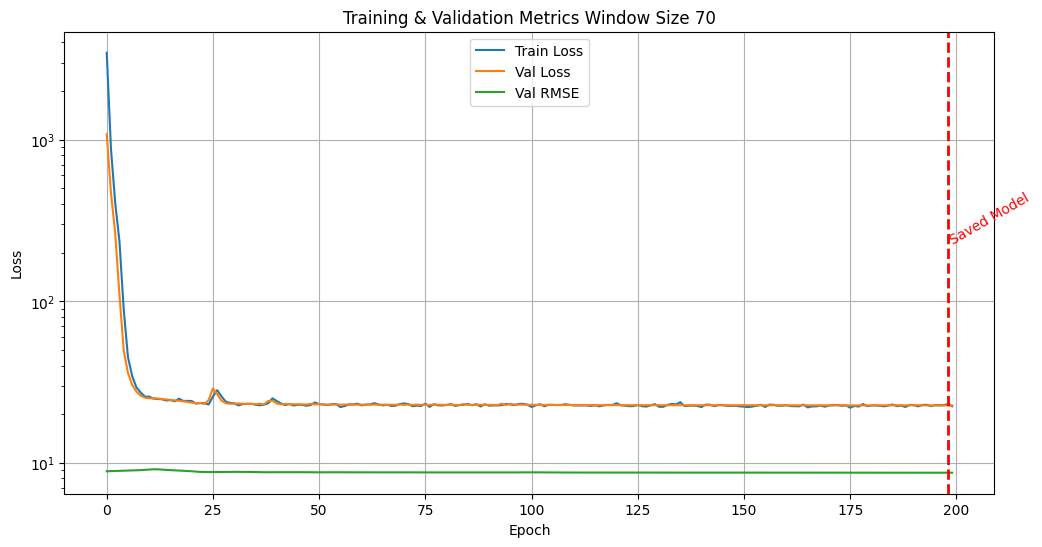

Test RMSE :  6.113626003265381
## 🧠 Model
Last model window :  last_model_window_80_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hu

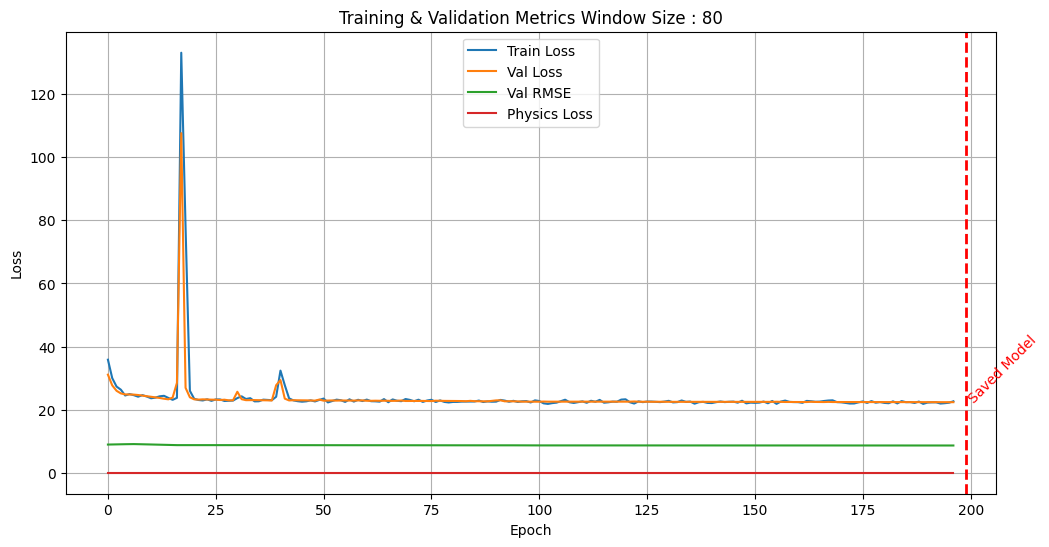

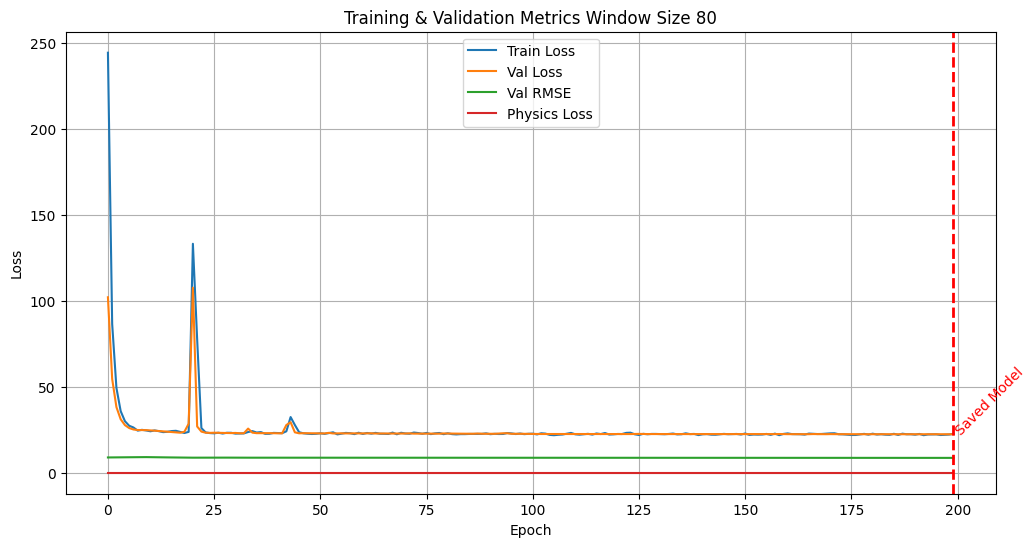

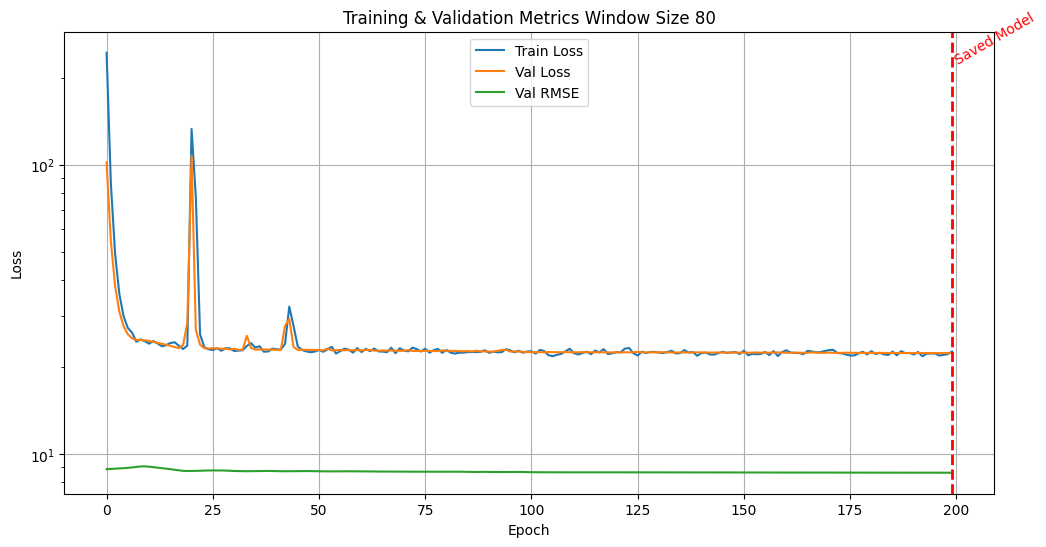

Test RMSE :  5.9131760597229
## 🧠 Model
Last model window :  last_model_window_90_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust

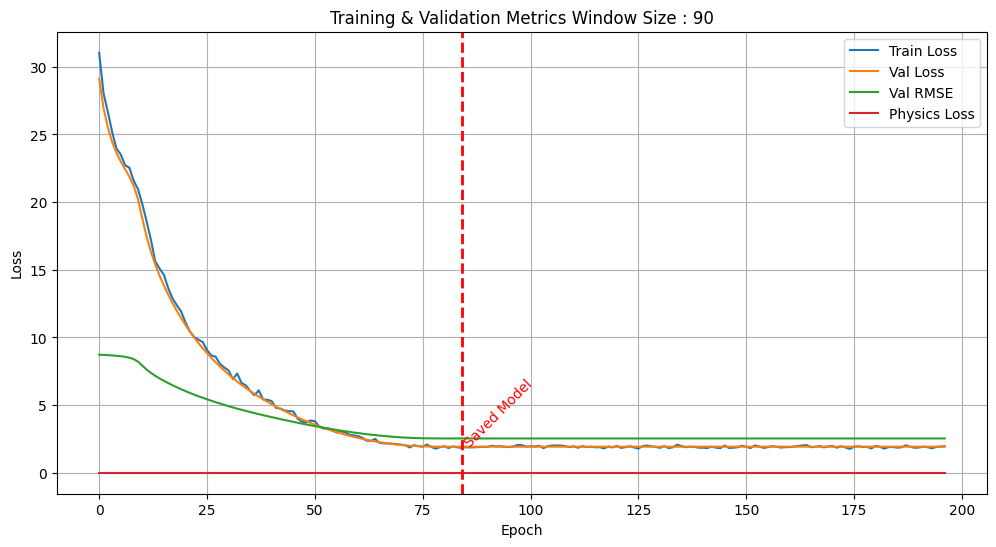

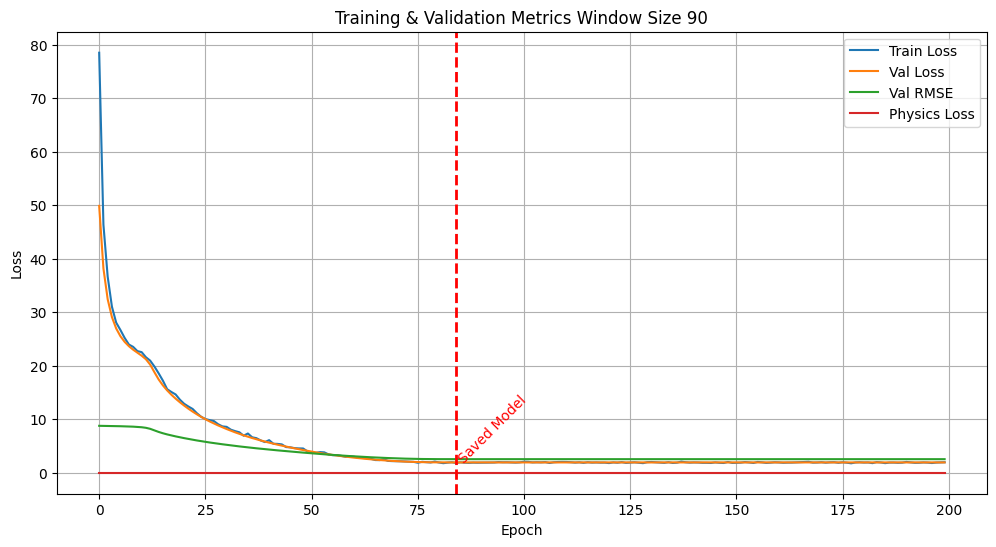

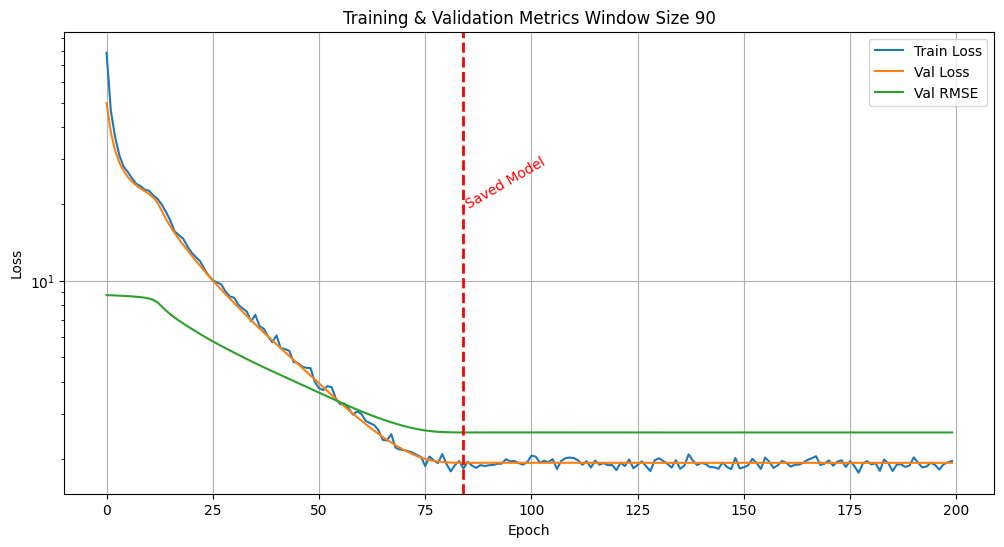

Test RMSE :  1.766080379486084
## 🧠 Model
Last model window :  last_model_window_100_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

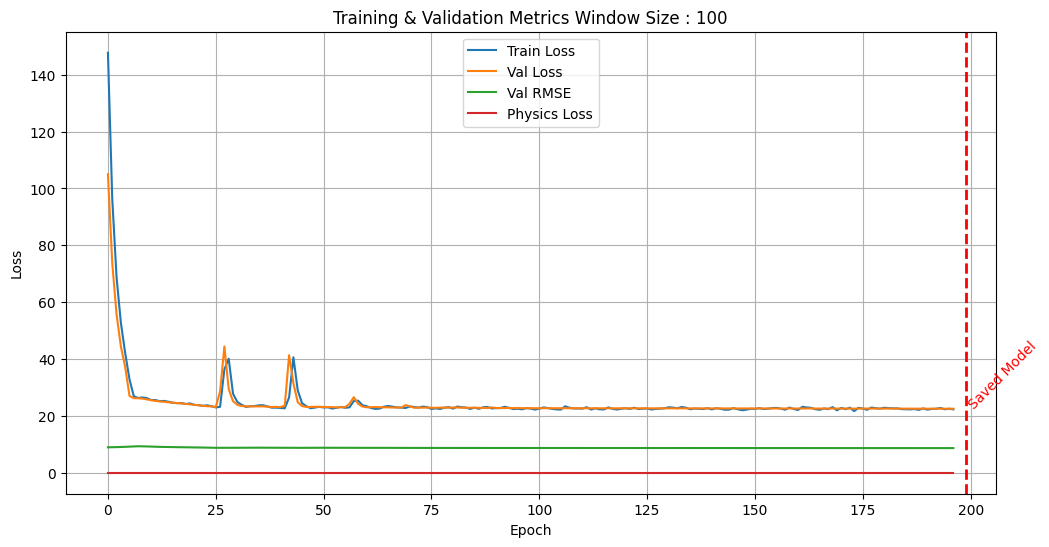

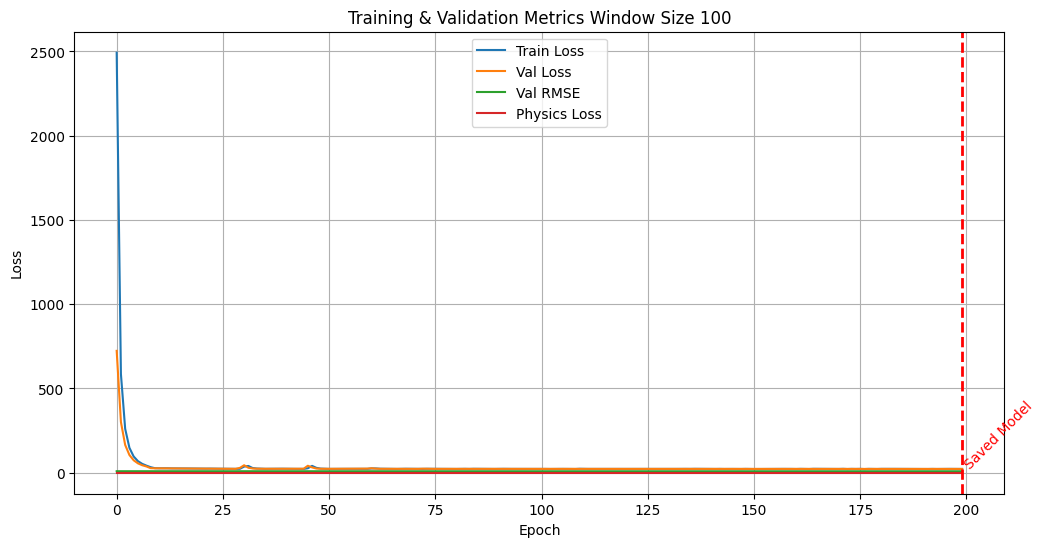

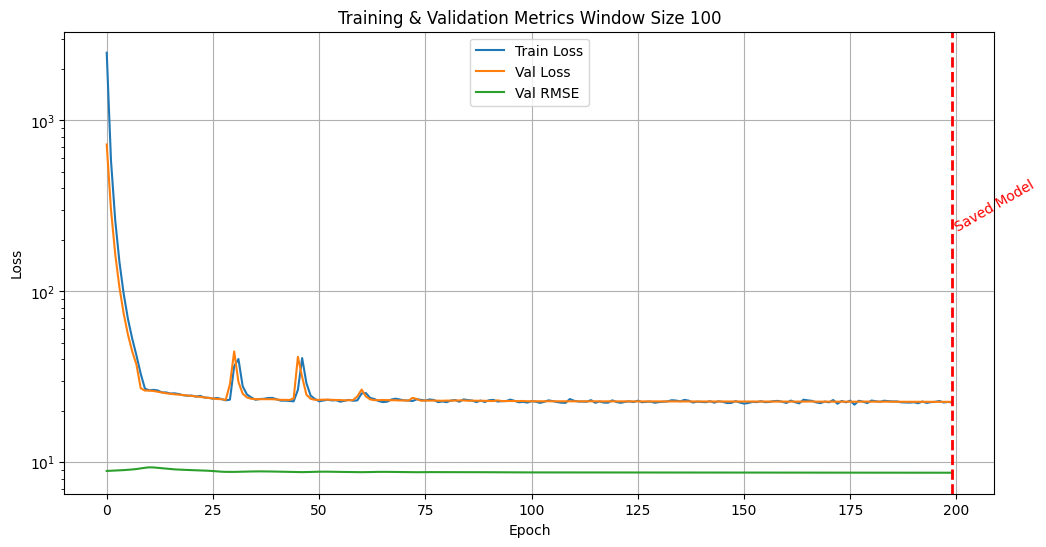

Test RMSE :  6.043571949005127
## 🧠 Model
Last model window :  last_model_window_500_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-h

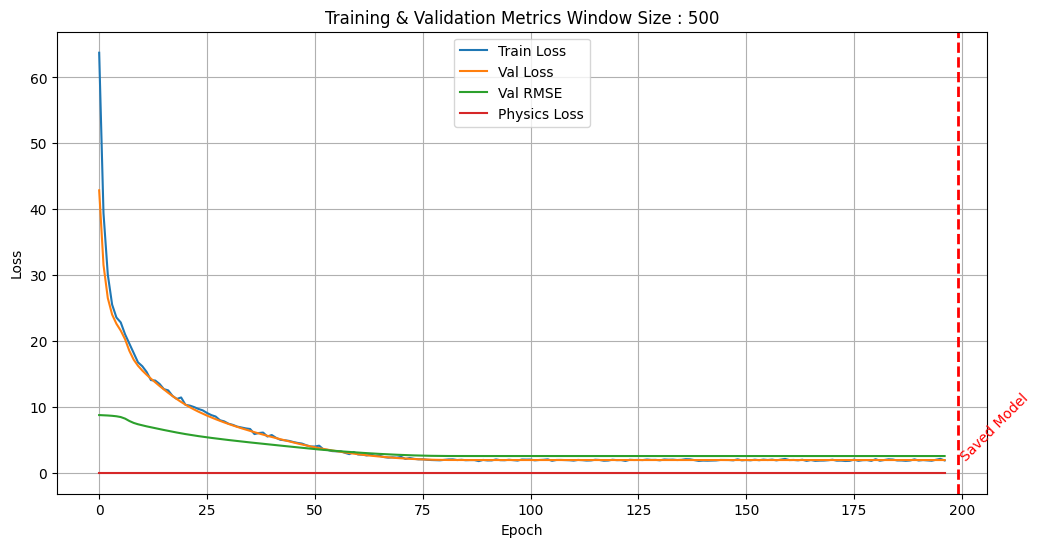

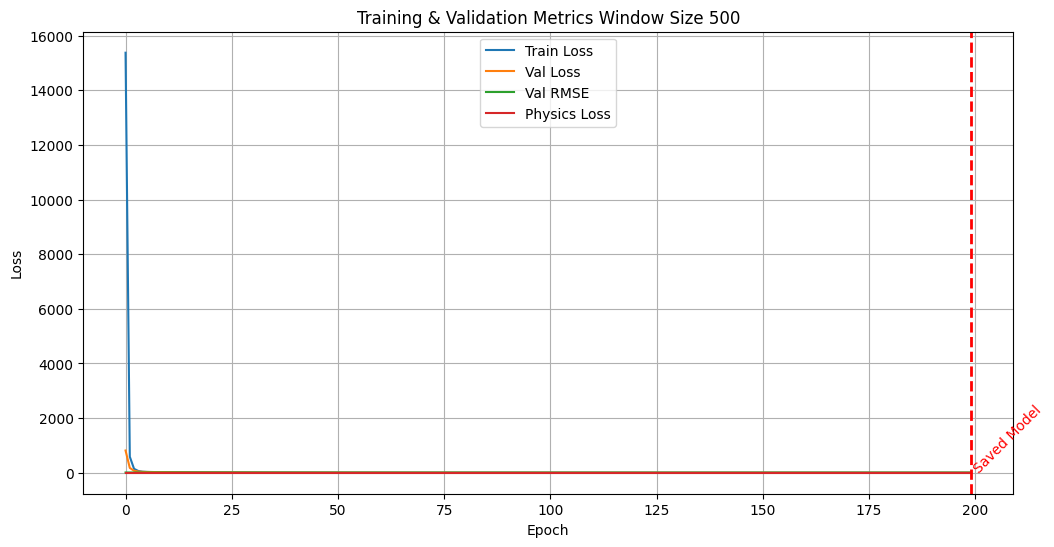

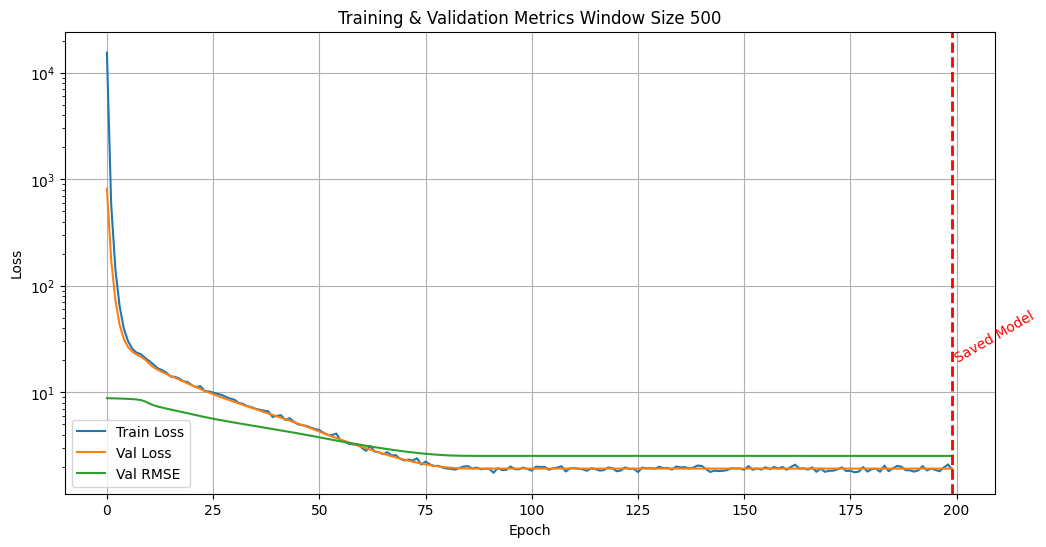

Test RMSE :  1.7643643617630005
## 🧠 Model
Last model window :  last_model_window_1000_model_pinn.pth
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8

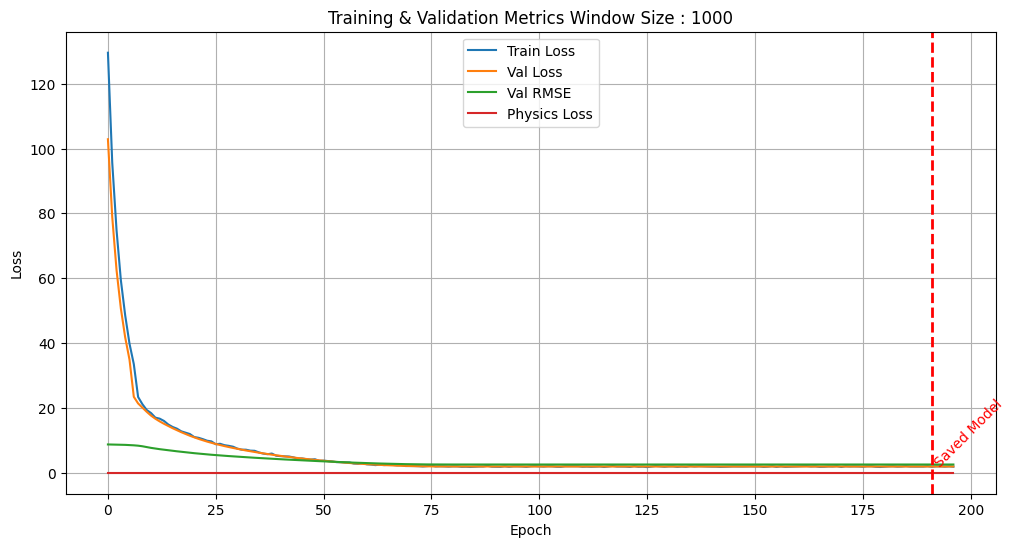

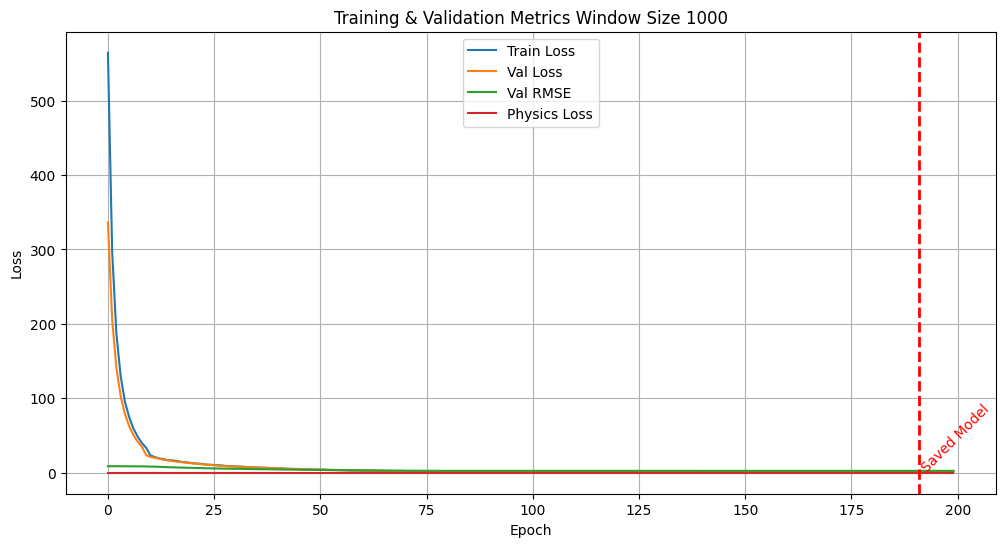

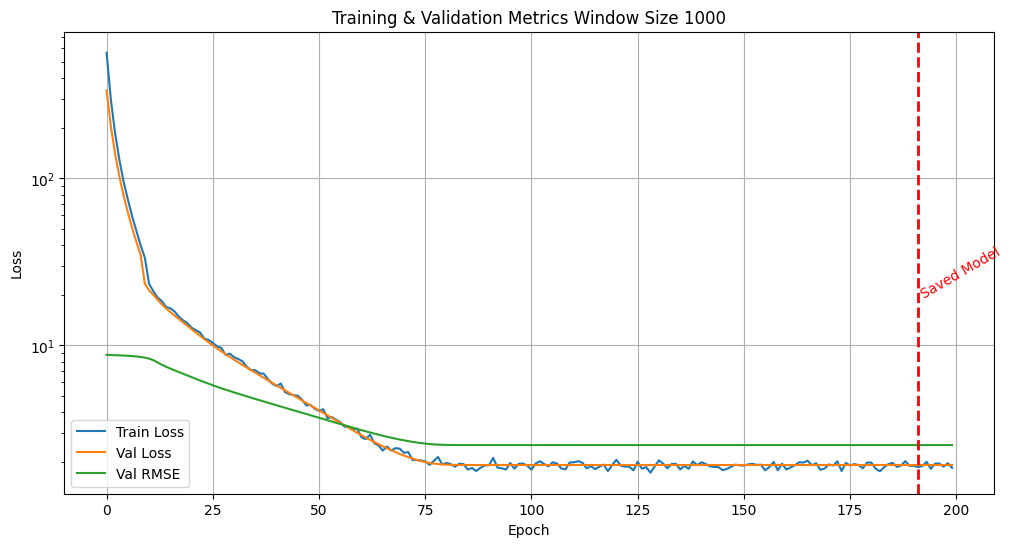

Test RMSE :  1.7659931182861328


In [4]:
for WINDOW_SIZE in WINDOW_SIZES:
    #OUTPUT_SIZE = WINDOW_SIZE
    print("## 🧠 Model")
    if model_type == 'lstm':
        model = LSTMModel(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE).to(device) # values for multioutput model
        last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
        print("Last model window : ",last_model_path)
    if model_type == 'seq2seq-lstm':
        model = Seq2SeqLSTM(INPUT_SIZE,64,32,OUTPUT_SIZE).to(device) # values from previously working tensorflow model # 1, 64, 8, 1 
        last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
        print("Last model window : ",last_model_path)
    if model_type == 'pinn':
        model = PhysicsInformedLSTM(input_size=INPUT_SIZE).to(device) # values for multioutput model
        last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
        print("Last model window : ",last_model_path)
    #### PREPARE ALL DATA ####
    ### DONT RUN AS LOOP
    def give_paths_get_loaders(paths,data_type,shuffle=False):
        X_list, y_list, y_target = get_x_y_lists(paths)

        batch_size = torch.cat(X_list, dim=0).shape[0]
        
        if INPUT_SIZE == 1:
            # Concatenate all X and y
            X_1,y_1,y_2 = torch.cat(X_list, dim=0).unsqueeze(-1),torch.cat(y_list, dim=0).view(batch_size,-1),torch.cat(y_target, dim=0).view(batch_size,-1)
        else:
            X_1,y_1,y_2 = torch.cat(X_list, dim=0).squeeze(2),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE),torch.cat(y_target, dim=0).view(-1,INPUT_SIZE)
        
        print(f" X_{data_type} shape : {X_1.shape} , y_{data_type} shape : {y_1.shape} ，y_2{data_type} shape: {y_2.shape}" )
        
        #DataLoader
        print("load : ")
        loader = DataLoader(TensorDataset(X_1, y_1, y_2), batch_size=32, shuffle=shuffle)
        print(f"{data_type}loader lengths : ",loader.__len__())
        return loader,X_1,y_1, y_2
    
    data_use = {
        0:["train"],1:["val"],2:["test"]
    }
    train_loader,X_train,y_train,y_train_target= give_paths_get_loaders(train_paths,data_use[0],shuffle=True)
    val_loader,X_val,y_val,y_val_target= give_paths_get_loaders(val_paths,data_use[1])
    test_loader,X_test,y_test,y_test_target = give_paths_get_loaders(test_paths,data_use[2])
    #break
    print('''##
    ### 📈 Gompertz Function (Physics Law)
    
    * `x`: Time (or cycle number)
    
    * `k`: Max value (e.g., max capacity)
    
    * `a`, `b`: Shape parameters''')
    
    def gompertz_func(x, k, a, b):
        return k * torch.exp(-a * torch.exp(-b * x))
    
    print("## 🧠 Loss Functions\n")
    
    print('''## ⚙️ 1. Data-Informed Loss Function
    a data loss (what the LSTM learns from data)
    
    * Mean Squared Error for Training
    * RMSE for autoregressive approximation of compound error
    
    ## ⚙️ 2. Physics-Informed Loss Function
    You combine a data loss (what the LSTM learns from data) and a physics loss (how well it conforms to Gompertz).
    
    * `alpha`: controls how strongly physics is enforced.''')
        
    def pinn_loss(prediction, target, x, k, a, b, alpha=0.5):
        data_loss = F.mse_loss(prediction, target)
        physics_pred = gompertz_func(x, k, a, b) #this needs to be refined !!!
        physics_loss = F.mse_loss(prediction, physics_pred)
        return data_loss + alpha * physics_loss, data_loss.item(), physics_loss.item()
    
    def data_loss_func(prediction, target, x, alpha=1.0):
        data_loss = F.mse_loss(prediction, target)
        return data_loss, data_loss.item() , None

    def rul_consistency_loss(prediction, true_rul_target, failure_threshold=0.7, lambda_rul=0.1):
        """
        Calculates the error between the True RUL and the RUL calculated 
        from the predicted Gompertz parameters at the failure threshold.
        
        Formula: RUL_calc = (a - ln(ln(k / 0.7))) / b
        
        prediction:      [Batch, 3] (Predicted k, a, b)
        true_rul_target: [Batch, 1] (The ground truth RUL for each sample)
        failure_threshold: Float (e.g., 0.7 for 70% capacity)
        """
        
        # 1. Extract Parameters
        # We do NOT unsqueeze to [Batch, 1, 1] because RUL is just one number per battery, not a sequence.
        # Shape: [32, 1]
        k_pred = prediction[:, 0:1] 
        a_pred = prediction[:, 1:2]
        b_pred = prediction[:, 2:3]
        
        # 2. Safety Check: k must be > threshold
        # If the max capacity (k) is predicted to be LOWER than 0.7, the battery never 'failed' 
        # (it started broken), which breaks the math. We clamp k to be at least 0.7001.
        k_safe = torch.clamp(k_pred, min=failure_threshold + 0.0001)
    
        # 3. The Inverse Gompertz Formula for RUL
        # y = 0.7 (fixed)
        # x (RUL) = (a - ln(ln(k / 0.7))) / b
        
        ratio = k_safe / failure_threshold
        
        # We create a scalar tensor for the threshold to ensure device compatibility
        inner_log = torch.log(ratio)
        double_log = torch.log(inner_log + 1e-6)
        
        # Calculated RUL based on physics parameters
        rul_calc = (a_pred - double_log) / (b_pred + 1e-6)
    
        # 4. Calculate MSE between Physics-RUL and Ground-Truth RUL
        # true_rul_target must be shape [32, 1]
        rul_loss = F.mse_loss(rul_calc, true_rul_target)
        
        return lambda_rul * rul_loss
    
    def physics_informed_loss(prediction, target, target_y, x, alpha=1.0, lambda_ode=0.1, lambda_rul=0.05):
        """
        prediction: (Batch, 3) -> [32, 3] (One set of k,a,b per sequence)
        target:     (Batch, 3) -> [32, 3]
        x:          (Batch, Window, 1) -> [32, 5, 1] (Time steps)
        """
        
        # 1. Standard Data Loss (MSE on parameters k, a, b)
        # prediction and target are both [32, 3], so this works directly.
        data_loss = F.mse_loss(prediction, target)
    
        # 2. Prepare Physics Inputs
        if not x.requires_grad:
            x.requires_grad_(True)
    
        # --- Slicing & Reshaping (THE FIX) ---
        # Prediction is [32, 3]. We need [32, 1, 1] to broadcast over the Window dimension of x (5).
        
        # Take column 0, keep dims -> [32, 1], then add extra dim -> [32, 1, 1]
        k_pred = prediction[:, 0:1].unsqueeze(1) 
        a_pred = prediction[:, 1:2].unsqueeze(1) 
        b_pred = prediction[:, 2:3].unsqueeze(1) 

        # Inside physics_informed_loss, before math operations:
        k_pred = torch.clamp(k_pred, min=0, max=2)
        a_pred = torch.clamp(a_pred, min=-5, max=-1)
        b_pred = torch.clamp(b_pred, min=-30, max=-3)
        # Now:
        # b_pred: [32, 1, 1]
        # x:      [32, 5, 1]
        # Result: [32, 5, 1] (Broadcasting works!)
        exponent_term = a_pred - (b_pred * x)
        exponent_term = torch.clamp(exponent_term, min=-10.0, max=10.0)

        y_pred_curve = k_pred * torch.exp(-torch.exp(exponent_term))
    
        # --- Physics Gradients ---
        
        # Calculate dy/dx (autograd)
        dydx_autograd = torch.autograd.grad(
            outputs=y_pred_curve,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred_curve),
            create_graph=True, 
            retain_graph=True,
            only_inputs=True
        )[0]
    
        # Calculate dy/dx (ODE Equation)
        # dy/dx = b * y * e^(a-bx)
        dydx_ode = b_pred * y_pred_curve * torch.exp(exponent_term)
    
        # Residual
        ode_residual = dydx_autograd - dydx_ode
        ode_loss = torch.mean(ode_residual ** 2)

        #add RUL loss
        # loss_rul = inverse_time_loss(prediction, target_y, x_seq)
        loss_rul = rul_consistency_loss(prediction, target_y, failure_threshold=0.7, lambda_rul=lambda_rul)
        
        total_loss = (alpha * data_loss) + (lambda_ode * ode_loss) + loss_rul
    
        return total_loss, data_loss.item(), ode_loss.item()
        
    epoch = 0
    avg_train_loss = 0.0
    avg_val_loss = 0.0
    data_loss = 0.0
    phys_loss = None  # Only set if you're using physics loss
    
    if mode == 0:
        criterion = physics_loss #??
        best_model_path = f'best_pysics_model-window-{WINDOW_SIZE}.pth' #??
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
    if mode == 1:
        criterion = data_loss_func
        best_model_path = f'best_lstm_model-window-{WINDOW_SIZE}.pth'
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f}"
    if mode == 2:
        # phys_loss = 0.0 # Only set if you're using physics loss
        # criterion = pinn_loss
        # best_model_path = f'best_pinn_lstm_model-window-{WINDOW_SIZE}.pth'
        # loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
        criterion = physics_informed_loss
        best_model_path = f'best_lstm_model-window-{WINDOW_SIZE}.pth'
        loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f}"
    
    print("## 🛠️ Parameter Strategy")
    
    # k = nn.Parameter(torch.tensor(1.0))
    # a = nn.Parameter(torch.tensor(0.1))
    # b = nn.Parameter(torch.tensor(0.1))
    # Include in optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=100)
    
    print("## 🔁 Training Loop")
    def compute_rmse(pred, target):
        return torch.sqrt(F.mse_loss(pred, target))
        
    train_losses = []
    val_losses = []
    val_rmses = []
    data_losses = []
    phys_losses = []
    
    best_val_loss = float('inf')
    best_epoch = 0
    
    # # 2. Create the sequence from 1 to WINDOW_SIZE
    # # torch.arange(start, end) excludes the end, so we use WINDOW_SIZE + 1
    # x_raw = torch.arange(1, WINDOW_SIZE + 1, dtype=torch.float32, device=device)
    
    # # 3. Scale it (divide by 10000)
    # x_scaled = x_raw / 10000.0
    
    # # 4. Reshape to (N, 1) and enable gradients
    # # .view(-1, 1) makes it a column vector. 
    # # .requires_grad_(True) is vital for the physics loss (dydx calculation).
    # x_seq = x_scaled.view(-1, 1).requires_grad_(True)

    # Provide as a train function
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_data_loss = 0
        for X_batch, y_batch, y_target in train_loader:
            optimizer.zero_grad()
            #Set computing environment
            X_batch, y_batch, y_target = X_batch.to(device), y_batch.to(device), y_target.to(device)
            #Predict
            y_pred = model(X_batch)
            

            # Create x_seq for physics loss
            #x_seq = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_batch.size(0), 1).to(X_batch.device)
            x_seq = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_batch.size(0), 1).unsqueeze(-1).to(X_batch.device)
            
            loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq, alpha=0.3)
            # loss.backward()
            # optimizer.step()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # <--- ADD THIS
            optimizer.step()
            total_data_loss += data_loss#.item() #TRY
            total_loss += loss.item()
        
        # Adjust learning rate
        scheduler.step()
        avg_data_loss = total_data_loss / len(train_loader)
        avg_train_loss = total_loss / len(train_loader)
    
        # ---- Validation Pass ----
        model.eval()
        val_loss_total = 0.0
        val_rmse = 0.0

        if epoch%20 == 0:
            test_rmse = 0 
            for X_batch, y_batch, y_target in test_loader:
                # Calculate RMSE directly
                y_pred = model(X_batch.to(device)).cpu().detach().numpy()
                test_rmse += root_mean_squared_error(y_batch, y_pred)
                print('\n Test RMSE : ',test_rmse,'\n Epoch : ', epoch,'\n Target : ',y_batch,'\n Prediction : ',y_pred,'\n')
        #with torch.no_grad():
        for X_val_batch, y_val_batch, y_val_target_batch in val_loader:
            #Set computing environment
            X_val_batch, y_val_batch, y_val_target_batch = X_val_batch.to(device), y_val_batch.to(device), y_val_target_batch.to(device)
            #Predict
            y_val_pred = model(X_val_batch)

            #ADD A METRIC
            val_rmse += compute_rmse(y_val_pred, y_val_batch)

            x_seq_val = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_val_batch.size(0), 1).unsqueeze(-1).to(X_val_batch.device)
            # = x_seq#torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_val_batch.size(0), 1).to(X_val_batch.device)
            val_loss, _, _ = criterion(y_val_pred, y_val_batch, y_val_target_batch, x_seq_val, alpha=0.3)

            val_loss_total += val_loss.item()
    
        avg_val_loss = val_loss_total / len(val_loader)
        avg_val_rmse = val_rmse / len(val_loader)
        # Save model if validation improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Saved best model at epoch {epoch+1} (Val Loss = {best_val_loss:.8f})")
        if epoch+1 == num_epochs:
            torch.save(model.state_dict(),last_model_path)
            print(f"✅ Saved last model at epoch {epoch+1} ")
     
    
        if mode == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
        if mode == 1:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f}")
        if mode == 2:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f}")
            #print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_rmses.append(avg_val_rmse.item())  # assuming avg_val_rmse is a tensor
        data_losses.append(avg_data_loss)   # assuming this is the last batch's data loss
        phys_losses.append(phys_loss)   # assuming this is the last batch's physics loss
    
    model.load_state_dict(torch.load(best_model_path))
    
    np.savez(f"training_metrics__window_{WINDOW_SIZE}_model_{model_type}.npz",
             train_losses=train_losses,
             val_losses=val_losses,
             val_rmses=val_rmses,
             data_losses=data_losses,
             phys_losses=phys_losses)
    print("Plot losses after training 3:")
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses[3:], label="Train Loss")
    plt.plot(val_losses[3:], label="Val Loss")
    plt.plot(val_rmses[3:], label="Val RMSE")
    #plt.plot(data_losses[3:], label="Data Loss")
    plt.plot(phys_losses[3:], label="Physics Loss")
    x_line = best_epoch 
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training & Validation Metrics Window Size : {WINDOW_SIZE}")
    plt.grid(True)
    plt.savefig(fname = f"history-from-3-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.plot(val_rmses, label="Val RMSE")
    #plt.plot(data_losses, label="Data Loss")
    plt.plot(phys_losses, label="Physics Loss")
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training & Validation Metrics Window Size {WINDOW_SIZE}")
    plt.grid(True)
    plt.savefig(fname = f"history-full-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.plot(val_rmses, label="Val RMSE")
    #plt.plot(data_losses, label="Data Loss")
    #plt.plot(phys_losses, label="Physics Loss")
    plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
    plt.text(x_line, best_val_loss*10, 'Saved Model', rotation=30, color='red')
    plt.yscale('log')  # visualize on log scale
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training & Validation Metrics Window Size {WINDOW_SIZE}")
    plt.grid(True)
    plt.savefig(fname = f"history-full-log-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
    plt.show()

    test_rmse = 0 
    
    for X_batch, y_batch, y_target in test_loader:
        # Calculate RMSE directly
        test_rmse += root_mean_squared_error(y_batch, model(X_batch.to(device)).cpu().detach().numpy())
    print('Test RMSE : ',test_rmse)

In [5]:
# help(TensorDataset)

In [6]:
# # Use X_batch.shape[1] to dynamically get the correct window size (e.g., 6)
# current_batch_size = X_batch.size(0)
# current_window_size = X_batch.size(1) 

# x_seq = torch.arange(current_window_size, dtype=torch.float32, device=X_batch.device)
# x_seq = x_seq.view(1, -1, 1).repeat(current_batch_size, 1, 1) # Shape: [32, 6, 1]

# loss, data_loss, phys_loss = criterion(y_pred, y_batch, x_seq, alpha=0.5)

In [7]:
for sample in train_loader:
    print(sample)
    break

[tensor([[[0.9682],
         [0.9448],
         [0.9453],
         ...,
         [0.8714],
         [0.8714],
         [0.8714]],

        [[0.9820],
         [0.9806],
         [0.9801],
         ...,
         [0.9144],
         [0.9145],
         [0.9140]],

        [[0.9717],
         [0.9550],
         [0.9560],
         ...,
         [0.8956],
         [0.8956],
         [0.8956]],

        ...,

        [[0.9664],
         [0.9526],
         [0.9531],
         ...,
         [0.9018],
         [0.9027],
         [0.9018]],

        [[0.9464],
         [0.9454],
         [0.9449],
         ...,
         [0.8507],
         [0.8507],
         [0.8505]],

        [[0.9877],
         [0.9865],
         [0.9858],
         ...,
         [0.9248],
         [0.9246],
         [0.9243]]]), tensor([[  0.9742,  -3.9299, -17.6073],
        [  1.0052,  -3.4071, -10.8766],
        [  0.9830,  -3.7801, -13.9536],
        [  0.9585,  -3.9786, -16.7533],
        [  0.9830,  -3.6081, -11.8800],
    

In [8]:
sample[0]

tensor([[[0.9682],
         [0.9448],
         [0.9453],
         ...,
         [0.8714],
         [0.8714],
         [0.8714]],

        [[0.9820],
         [0.9806],
         [0.9801],
         ...,
         [0.9144],
         [0.9145],
         [0.9140]],

        [[0.9717],
         [0.9550],
         [0.9560],
         ...,
         [0.8956],
         [0.8956],
         [0.8956]],

        ...,

        [[0.9664],
         [0.9526],
         [0.9531],
         ...,
         [0.9018],
         [0.9027],
         [0.9018]],

        [[0.9464],
         [0.9454],
         [0.9449],
         ...,
         [0.8507],
         [0.8507],
         [0.8505]],

        [[0.9877],
         [0.9865],
         [0.9858],
         ...,
         [0.9248],
         [0.9246],
         [0.9243]]])

In [9]:
# help(model)
for X_batch, y_batch, y_target in train_loader:
    #optimizer.zero_grad()
    #Set computing environment
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

In [10]:
model(X_batch)

tensor([[  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1813],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1813],
        [  0.9778,  -3.6937, -14.1809],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6937, -14.1812],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6937, -14.1812],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1812],
        [  0.9777,  -3.6938, -14.1813],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1813],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9778,  -3.6937, -14.1811],
        [  0.9778,  -3.6937, -14.1809]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [11]:
X_batch.shape

torch.Size([23, 1001, 1])

In [12]:
y_batch.shape

torch.Size([23, 3])

In [13]:
X_batch

tensor([[[0.9709],
         [0.9521],
         [0.9526],
         ...,
         [0.9052],
         [0.9051],
         [0.9051]],

        [[0.9659],
         [0.9649],
         [0.9640],
         ...,
         [0.9011],
         [0.9011],
         [0.9011]],

        [[0.9464],
         [0.9454],
         [0.9449],
         ...,
         [0.8507],
         [0.8507],
         [0.8505]],

        ...,

        [[0.9707],
         [0.9532],
         [0.9537],
         ...,
         [0.9024],
         [0.9024],
         [0.9019]],

        [[0.9341],
         [0.9331],
         [0.9327],
         ...,
         [0.8138],
         [0.8133],
         [0.8128]],

        [[0.9637],
         [0.9618],
         [0.9603],
         ...,
         [0.7599],
         [0.7594],
         [0.7594]]], device='cuda:0')

In [14]:
for X_batch, y_batch, y_target in test_loader:
    print(model(X_batch.to(device)))
    print(y_batch)
    break

tensor([[  0.9777,  -3.6937, -14.1811],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1812],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6937, -14.1811],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6937, -14.1811],
        [  0.9777,  -3.6938, -14.1815],
        [  0.9777,  -3.6938, -14.1814],
        [  0.9777,  -3.6938, -14.1812]], device='cuda:0',
       grad_fn=<CatBackward0>)
tensor([[  0.9456,  -4.3333, -23.9607],
        [  0.9895,  -3.5146, -13.6811],
        [  0.9878,  -3.2906,  -8.2867],
        [  0.9588,  -3.6402, -15.3791],
        [  0.9965,  -3.4288, -12.4189],
        [  0.9443,  -4.2489, -22.6408],
        [  0.9844,  -3.3709,  -8.3641],
        [  0.9919,  -3.1226, -14.7542],
        [  0.9828,  -3.8037, -13.5150],
        [  0.9680,  -3.9820, -14.9830],
        [  0.9476,  -4.0221, -18.8191]])


In [15]:
test_rmse = 0 

for X_batch, y_batch,y_target in test_loader:
    # Calculate RMSE directly
    y_pred = model(X_batch.to(device)).cpu().detach().numpy()
    test_rmse += root_mean_squared_error(y_batch, y_pred)
print('Test RMSE : ',test_rmse)

Test RMSE :  1.7659931182861328


In [16]:
#['6-6', '8-6', '10-1', '6-8', '8-8', '10-7', '10-6', '7-6', '4-5', '10-4', '3-1', '8-1', '9-6', '1-2', '6-1', '6-2', '8-5', '5-3', '2-5', '9-4', '7-5', '1-1']
y_batch, y_pred, y_target

(tensor([[  0.9456,  -4.3333, -23.9607],
         [  0.9895,  -3.5146, -13.6811],
         [  0.9878,  -3.2906,  -8.2867],
         [  0.9588,  -3.6402, -15.3791],
         [  0.9965,  -3.4288, -12.4189],
         [  0.9443,  -4.2489, -22.6408],
         [  0.9844,  -3.3709,  -8.3641],
         [  0.9919,  -3.1226, -14.7542],
         [  0.9828,  -3.8037, -13.5150],
         [  0.9680,  -3.9820, -14.9830],
         [  0.9476,  -4.0221, -18.8191]]),
 array([[  0.97774994,  -3.693721  , -14.181114  ],
        [  0.97774875,  -3.6937935 , -14.181376  ],
        [  0.97774816,  -3.6938233 , -14.181482  ],
        [  0.97774935,  -3.693758  , -14.181246  ],
        [  0.9777485 ,  -3.6938083 , -14.181428  ],
        [  0.9777499 ,  -3.6937258 , -14.181133  ],
        [  0.9777483 ,  -3.6938236 , -14.181483  ],
        [  0.97774994,  -3.6937196 , -14.181108  ],
        [  0.9777484 ,  -3.6938167 , -14.181459  ],
        [  0.9777485 ,  -3.6938043 , -14.1814165 ],
        [  0.97774947,  -3.

In [17]:
def inverse_gompertz_func(y,k,a,b):
    return (a - np.log(np.log(k/y)))/b

for i, pred in enumerate(y_pred):
    k,a,b = y_pred[i][0],y_pred[i][1],y_pred[i][2]
    
    print(k,a,b)
    
    print(f'RUL : {inverse_gompertz_func(y=0.7,k=k,a=a,b=b)*10000:.0f} cycles')

0.97774994 -3.693721 -14.181114
RUL : 1832 cycles
0.97774875 -3.6937935 -14.181376
RUL : 1832 cycles
0.97774816 -3.6938233 -14.181482
RUL : 1832 cycles
0.97774935 -3.693758 -14.181246
RUL : 1832 cycles
0.9777485 -3.6938083 -14.181428
RUL : 1832 cycles
0.9777499 -3.6937258 -14.181133
RUL : 1832 cycles
0.9777483 -3.6938236 -14.181483
RUL : 1832 cycles
0.97774994 -3.6937196 -14.181108
RUL : 1832 cycles
0.9777484 -3.6938167 -14.181459
RUL : 1832 cycles
0.9777485 -3.6938043 -14.1814165
RUL : 1832 cycles
0.97774947 -3.6937506 -14.181221
RUL : 1832 cycles


In [18]:
# Define the function
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

def gompertz_exponent_func(x,k,a,b):
    return a-(b*x)

In [19]:
# Check if k,a and b are the correct k, a and b
path = "../input/generate-hust-data-gompertz-k-a-b/"
files = os.listdir(path)
k_s, a_s, b_s ,e_s = [], [],[],[]
#print(files)
files = [f for f in files if re.match(r'^\d', f) and f.endswith('-hust_gompertz_params.csv')]
for file in files:
    df = pd.read_csv(path+file)
    #print(df.head())
    df['exponent'] =  gompertz_exponent_func(x=df['rul']/10000,k=df['k'],a=df['a'],b=df['b'])
    
    answers = file[:3],list(df['k'])[-1], list(df['a'])[-1], list(df['b'])[-1], list(df['exponent'])[-1]
    k_s.append(answers[1]), a_s.append(answers[2]), b_s.append(answers[3]) , e_s.append(answers[4])
    print(answers)

('6-6', 0.999946950696718, -3.0463019901673665, -8.058702298233401, -3.045496119937543)
('8-7', 0.960536968518218, -3.8912779384551865, -13.448726573064285, -3.88993306579788)
('8-6', 0.9907509429027922, -3.6060510716281655, -10.801653050097192, -3.604970906323156)
('9-1', 0.9891766657708968, -3.6505840630566007, -12.21416655437278, -3.6493626464011633)
('10-', 0.9481215769904175, -4.211693705003083, -17.547137063751773, -4.209938991296708)
('6-8', 1.0107420560063778, -2.9030997786747967, -7.691465017103098, -2.9023306321730864)
('8-8', 0.98413059165122, -3.7445201053751354, -15.65627371654888, -3.7429544780034805)
('10-', 0.9786268880932516, -3.700592087534084, -14.445176742202348, -3.6991475698598637)
('3-5', 1.0099262656709476, -3.2992647017070773, -8.637530260413152, -3.298400948681036)
('5-1', 0.9967531041266844, -3.1470462327694158, -8.325162160953383, -3.1462137165533206)
('5-5', 0.9897916363777954, -3.3170924362716403, -14.18101023291364, -3.315674335248349)
('7-1', 0.971157280

In [20]:
min(k_s), max(k_s), min(a_s), max(a_s), min(b_s), max(b_s), min(e_s), max(e_s)

(0.9380190201332748,
 1.176959439132687,
 -4.519553698685354,
 -1.76136905371235,
 -27.431058619993472,
 -4.594320481289704,
 -4.5171884683848,
 -1.760909621664221)

In [21]:
df = pd.read_csv('../input/generate-hust-data-gompertz-k-a-b/hust_gompertz_params.csv')
df['exponent'] = df['a'] - df['b']
print(df[['file','k','a','b','rul']].head(50))
print(df[['file','k','a','b','rul']].tail(27))

        file         k         a          b   rul
0    6-6.csv  0.999947 -3.046302  -8.058702  2468
1    7-8.csv  0.974260 -3.848156 -14.075338  1938
2    5-3.csv  0.984412 -3.370905  -8.364135  2689
3    6-8.csv  1.010742 -2.903100  -7.691465  2450
4    5-5.csv  0.989792 -3.317092 -14.181010  1583
5    2-4.csv  0.966667 -3.666074 -16.745222  1499
6   10-3.csv  0.958764 -3.966747 -14.856416  1848
7    1-4.csv  0.967306 -3.925555 -18.654933  1500
8    6-3.csv  0.980676 -3.726281 -14.527733  1804
9    5-6.csv  0.992200 -3.234754  -8.788364  2460
10   8-3.csv  0.977851 -3.686572 -11.118307  2290
11   3-6.csv  0.985113 -3.474966  -9.437832  2491
12  10-4.csv  0.966029 -4.116645 -16.335191  1811
13   9-6.csv  0.989487 -3.514648 -13.681117  1742
14   3-2.csv  1.000270 -3.217233  -9.342928  2283
15   9-2.csv  0.986816 -3.552345 -11.455414  2143
16   9-7.csv  0.977538 -3.744889 -12.948923  2012
17   6-5.csv  0.971249 -3.576216 -11.063468  2178
18   4-8.csv  0.975867 -3.952479 -16.603498  1706
